# Análise *in silico* da mutagenicidade de moléculas em formato SMILES #

## Extração de Conhecimento de Dados Biológicos - 2022/2023 ##

### Mestrado em Bioinformática ###

- Cátia Silva - PG30435
- José Lemos - PG49838
- Paulo Seixal - PG49846
- Rúben Fernandes - PG49847

### Ínicio da segunda parte

Nesta segunda parte iremos realizar a análise preditiva da mutagenicidade dos compostos químicos, testando diferentes fingerprints enquanto features. Neste caso, optamos por testar várias combinações entre diferentes fingerprints e modelos preditivos (machine learning ou deep learning).

Esta segunda parte incluí ainda uma breve análise dos fngerprints (que também está presente na primeira parte), que servirá de transição entre as duas partes.

### Imports e packages 

In [1]:
import sys
!{sys.executable} -m pip install rdkit 
!{sys.executable} -m pip install pandas                               
!{sys.executable} -m pip install scikit-learn                                
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import Descriptors
from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole
from rdkit import DataStructs
from rdkit.Chem import PandasTools
from rdkit.Chem import MACCSkeys
from rdkit.Chem.rdMolDescriptors import GetHashedAtomPairFingerprintAsBitVect
from rdkit.Chem.rdMolDescriptors import GetHashedTopologicalTorsionFingerprintAsBitVect
from base64 import b64decode
from scipy.stats import chi2_contingency
from sklearn.feature_selection import SelectPercentile, f_classif
from scipy import stats
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.cluster.hierarchy import linkage, fcluster
from sklearn.datasets import make_blobs
from sklearn.cluster import AgglomerativeClustering, KMeans
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, matthews_corrcoef, precision_score, classification_report
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Reshape,Dropout
from keras.callbacks import ModelCheckpoint 
from model_util import fowlkes_mallows, bookmaker, dl_model_metrics, plot_acc_loss_dl

'c:\Users\Paulo' is not recognized as an internal or external command,
operable program or batch file.


'c:\Users\Paulo' is not recognized as an internal or external command,
operable program or batch file.
'c:\Users\Paulo' is not recognized as an internal or external command,
operable program or batch file.


In [11]:
df = pd.read_csv(r"ames.csv")
df

,ids,smiles,Y
0,Drug 0,O=[N+]([O-])c1ccc2ccc3ccc([N+](=O)[O-])c4c5ccc...,1
1,Drug 1,O=[N+]([O-])c1c2c(c3ccc4cccc5ccc1c3c45)CCCC2,1
2,Drug 2,O=c1c2ccccc2c(=O)c2c1ccc1c2[nH]c2c3c(=O)c4cccc...,0
3,Drug 3,[N-]=[N+]=CC(=O)NCC(=O)NN,1
4,Drug 4,[N-]=[N+]=C1C=NC(=O)NC1=O,1
...,...,...,...
7268,Drug 7587,CCCCCCCCCCCCOCCO,0
7269,Drug 7588,CC(CCc1ccccc1)c1ccccc1,0
7270,Drug 7593,CCOP(=S)(CC)Sc1ccccc1,0
7271,Drug 7598,C=C(C)C1CC=C(C)C(OC(C)=O)C1,0


In [12]:
df_features = pd.read_csv(r"ames_features.csv")
df_features

,MaxEStateIndex,MinEStateIndex,MaxAbsEStateIndex,MinAbsEStateIndex,qed,MolWt,HeavyAtomMolWt,ExactMolWt,NumValenceElectrons,NumRadicalElectrons,...,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea
0,11.663401,-0.396099,11.663401,0.008895,0.181963,342.310,332.230,342.06406,124.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,11.824743,-0.170602,11.824743,0.170602,0.269289,301.345,286.225,301.11030,112.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,14.431072,-0.378575,14.431072,0.128988,0.184582,646.614,628.470,646.11650,232.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,10.422196,-0.670278,10.422196,0.248657,0.103849,157.133,150.077,157.05997,60.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,10.521759,-0.752407,10.521759,0.278148,0.342148,138.086,136.070,138.01778,50.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7268,8.502606,0.150556,8.502606,0.150556,0.485970,230.392,200.152,230.22458,98.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,11.0,0.0
7269,2.303843,0.640191,2.303843,0.640191,0.700283,210.320,192.176,210.14085,82.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7270,5.671445,-1.672137,5.671445,0.713245,0.722425,246.337,231.217,246.03020,78.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7271,10.862176,-0.203597,10.862176,0.038935,0.498826,194.274,176.130,194.13068,78.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Fingerprints

</p>
<div style="text-align: justify">
As "fingerprints" na análise de moléculas SMILES referem-se a códigos numéricos ou binários que são gerados a partir da representação da estrutura molecular da molécula na forma de SMILES.
</div>
</p>
<div style="text-align: justify">
Esses códigos são úteis para descrever a estrutura molecular de uma molécula de forma concisa e eficiente, permitindo a sua rápida identificação e comparação com outras moléculas. Eles podem ser gerados usando uma variedade de algoritmos de codificação e podem incluir informações sobre a topologia molecular, subestruturas, propriedades químicas, entre outros.
</div>
</p>
<div style="text-align: justify">
As fingerprints podem ser usadas em várias aplicações, incluindo a análise de similaridade molecular, virtual screening e modelagem de QSAR (Quantitative Structure-Activity Relationship), onde as propriedades bioativas das moléculas são correlacionadas com suas características estruturais.
</div>
</p>
<div style="text-align: justify">
Deste modo, pretende-se utilizar as "fingerprints" como atributos para a predição da mutagenicidade, em que as selecionadas foram o algoritmo de Morgan, MACCS keys e PubChem. 
</div>

### CIRCULAR MORGAN FINGERPRINT
</p>
<div style="text-align: justify">
O algoritmo Morgan usa uma abordagem de vizinhança que considera os átomos adjacentes a um átomo central, bem como os átomos adjacentes a esses átomos, formando um conjunto de anéis (ou "círculos") que circundam o átomo central. A partir desses círculos, o algoritmo cria uma série de vetores binários, que são usados para gerar a Morgan Circular Fingerprint.</div>
</p>
<div style="text-align: justify">
A Morgan Circular Fingerprint é uma representação compacta da estrutura molecular de uma molécula e é frequentemente usada em aplicações de aprendizado de máquina para classificação, agrupamento e previsão de propriedades de moléculas. É particularmente útil na análise de grandes conjuntos de moléculas, pois permite uma análise rápida e eficiente da similaridade estrutural entre elas.</div>

In [13]:
class MFP:

    def __init__(self, fp, names):
        self.fp = fp
        self.names = names
    def __str__(self):
        return "%d bit MFP" % len(self.fp)
    def __len__(self):
        return len(self.fp)

def get_mfp(mol, radius=2, nBits=1024, useFeatures=False, counts=False, dtype=np.float32):
    arr = np.zeros((1,), dtype)
    
    if counts is True:
        info = {}
        fp = AllChem.GetHashedMorganFingerprint(mol, radius, nBits, useFeatures=useFeatures)
        DataStructs.ConvertToNumpyArray(fp, arr)
    else:
        DataStructs.ConvertToNumpyArray(AllChem.GetMorganFingerprintAsBitVect(mol, radius, nBits=nBits, useFeatures=useFeatures), arr)
    return MFP(arr, range(nBits))

In [14]:
#adicionar coluna com objetos rdkit
PandasTools.AddMoleculeColumnToFrame(df,'smiles')
[str(x) for x in  df.columns]

#remover linhas com falhas no processo de geração
df = df[~df['ROMol'].isnull()]
len(df)

7273

In [15]:
df['MFP'] = df['ROMol'].map(get_mfp)

In [16]:
X = np.array([x.fp for x in df['MFP']])
df['MFP_array'] = pd.Series(X.tolist())

#### t-SNE
</p>
<div style="text-align: justify">
t-SNE (t-distributed stochastic neighbor embedding) é um algoritmo de redução de dimensionalidade usado para visualizar dados de alta dimensão em um espaço de duas ou três dimensões. Ele mapeia pontos de dados de alta dimensão para um espaço de baixa dimensão preservando as distâncias entre eles o máximo possível. O t-SNE é especialmente útil para a visualização de dados complexos, onde se inclui os fingerprints.</div>

In [18]:
model = TSNE(n_components=2, random_state=0, perplexity=30, n_iter=5000)
tsne_drugs = model.fit_transform(X)

In [19]:
df['TSNE_C1'] = tsne_drugs.T[0]
df['TSNE_C2'] = tsne_drugs.T[1]

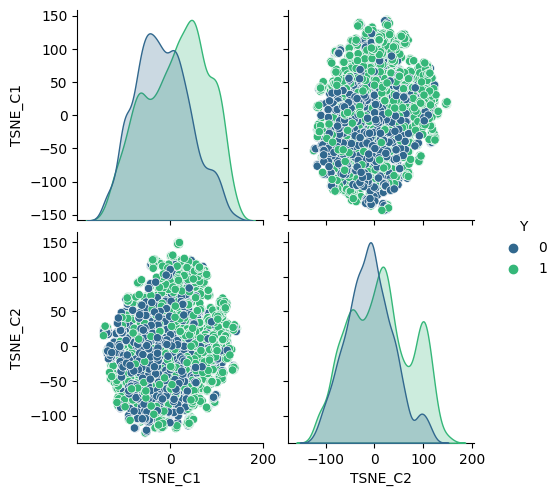

In [20]:
sns.pairplot(df, hue='Y', vars=['TSNE_C1', 'TSNE_C2'], palette='viridis')

#### Análise dos Componentes Principais (PCA)

In [21]:
pca = PCA(n_components=3, random_state=0)
pca_drugs = pca.fit_transform(X)

#obter as percentagens de variabilidade explicadas por cada PC
varia_exp = pca.explained_variance_ratio_
matriz_var_exp = np.diag(varia_exp*100)
print(matriz_var_exp)

[[5.170947  0.        0.       ]
 [0.        3.474958  0.       ]
 [0.        0.        2.9210973]]


In [22]:
df['pc1'] = pca_drugs.T[0]
df['pc2'] = pca_drugs.T[1]
df['pc3'] = pca_drugs.T[2]

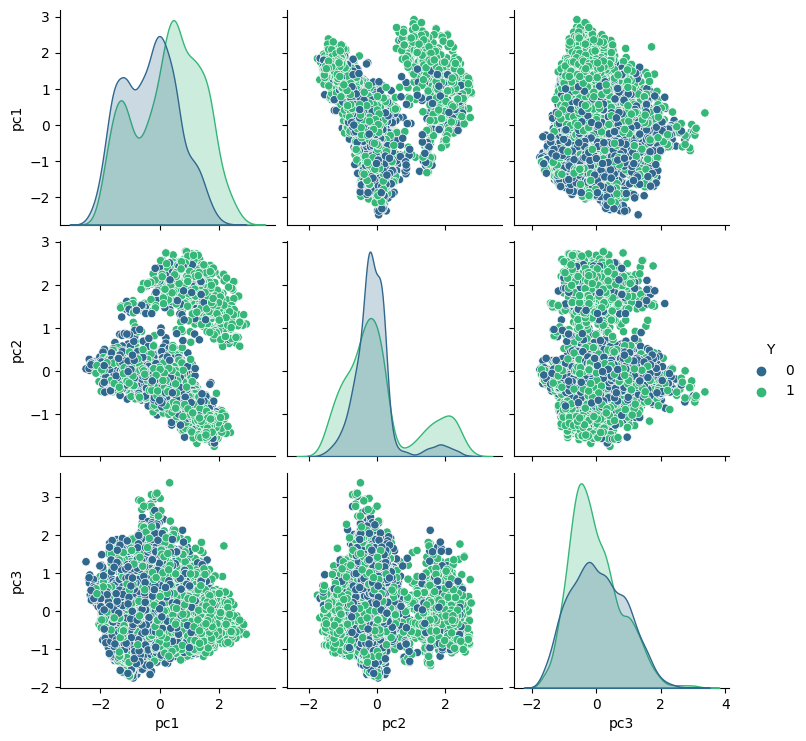

In [23]:
sns.pairplot(df, hue='Y', vars=['pc1', 'pc2', 'pc3'], palette='viridis')

No caso de dados de alta dimensionalidade, recomenda-se reduzir o número de dimensões com outro método antes de prosseguir com o t-SNE.

In [24]:
pca_model = PCA(n_components=30, random_state=0)
tsne_model = TSNE(n_components=2, random_state=0, perplexity=30, n_iter=5000)
tsne_pca = tsne_model.fit_transform(pca_model.fit_transform(X))

In [25]:
df['tsne_pca1'] = tsne_pca.T[0]
df['tsne_pca2'] = tsne_pca.T[1]

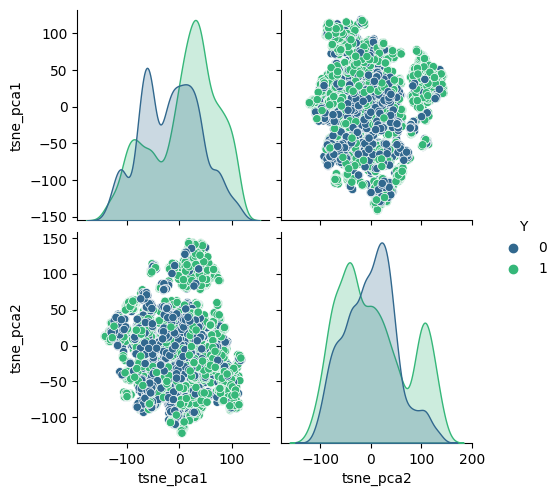

In [26]:
sns.pairplot(df, hue='Y', vars=['tsne_pca1', 'tsne_pca2' ], palette='viridis')

In [27]:
# Realiza o clustering hierárquico na matriz de similaridade
hierarchical_clustering = AgglomerativeClustering(n_clusters=3, affinity='euclidean', linkage='ward')
labels_hc = hierarchical_clustering.fit_predict(tsne_pca)

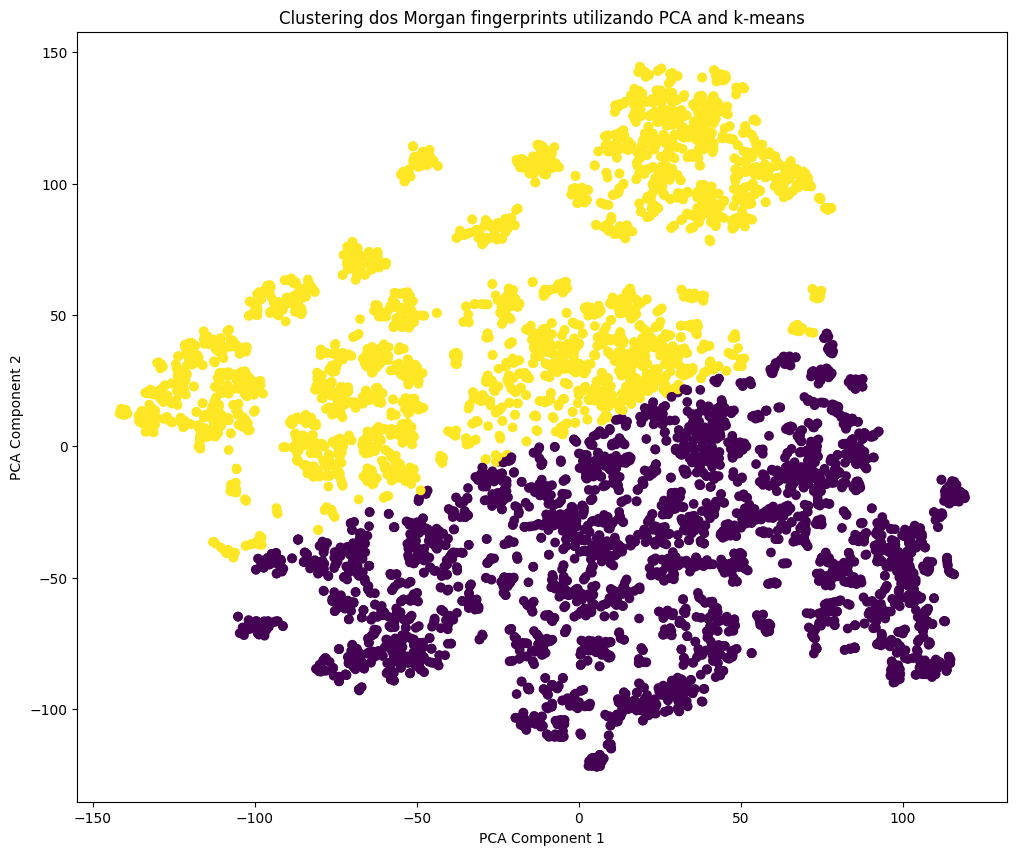

In [28]:
# Realiza o k-means clustering com k=3
kmeans = KMeans(n_clusters=2, random_state=0).fit(tsne_pca)
labels = kmeans.labels_
plt.figure(figsize=(12, 10))
plt.scatter(tsne_pca[:, 0], tsne_pca[:, 1], c=labels, cmap='viridis')
plt.title('Clustering dos Morgan fingerprints utilizando PCA and k-means')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.show()

### MACCS KEY FINGERPRINT
</p>
<div style="text-align: justify">
A MACCS Key Fingerprint é composta por um conjunto fixo de chaves binárias (bits) que representam a presença ou ausência de cada uma das subestruturas moleculares selecionadas. Essas subestruturas são derivadas de um conjunto de regras de estruturação desenvolvidas para incluir grupos funcionais comuns em moléculas bioativas.</div>

In [29]:
# Gera os MACCS fingerprints para cada molécula e adiciona ao df 
def maccs(mol):
    return MACCSkeys.GenMACCSKeys(mol)
df['maccs'] = df['smiles'].apply(lambda x: maccs(Chem.MolFromSmiles(x)))    

In [30]:
# calcula a matriz de similaridade dos fingerprints
mols = df['ROMol']
fps = [AllChem.GetMACCSKeysFingerprint(mol) for mol in mols]
similarity_matrix = np.zeros((len(mols), len(mols)))
for i in range(len(mols)):
    for j in range(i, len(mols)):
        similarity = DataStructs.FingerprintSimilarity(fps[i], fps[j])
        similarity_matrix[i, j] = similarity
        similarity_matrix[j, i] = similarity
print(similarity_matrix)

[[1.         0.75       0.33333333 ... 0.15384615 0.08       0.30357143]
 [0.75       1.         0.22       ... 0.17307692 0.1        0.27586207]
 [0.33333333 0.22       1.         ... 0.07407407 0.18181818 0.33962264]
 ...
 [0.15384615 0.17307692 0.07407407 ... 1.         0.20930233 0.22413793]
 [0.08       0.1        0.18181818 ... 0.20930233 1.         0.2745098 ]
 [0.30357143 0.27586207 0.33962264 ... 0.22413793 0.2745098  1.        ]]


In [31]:
# Realiza a PCA para reduzir a dimensionalidade dos dados
pca = PCA(n_components=2)
pca_data = pca.fit_transform(similarity_matrix)

In [32]:
# Realiza o clustering hierárquico na matriz de similaridade
hierarchical_clustering = AgglomerativeClustering(n_clusters=3, affinity='euclidean', linkage='ward')
labels_hc = hierarchical_clustering.fit_predict(pca_data)

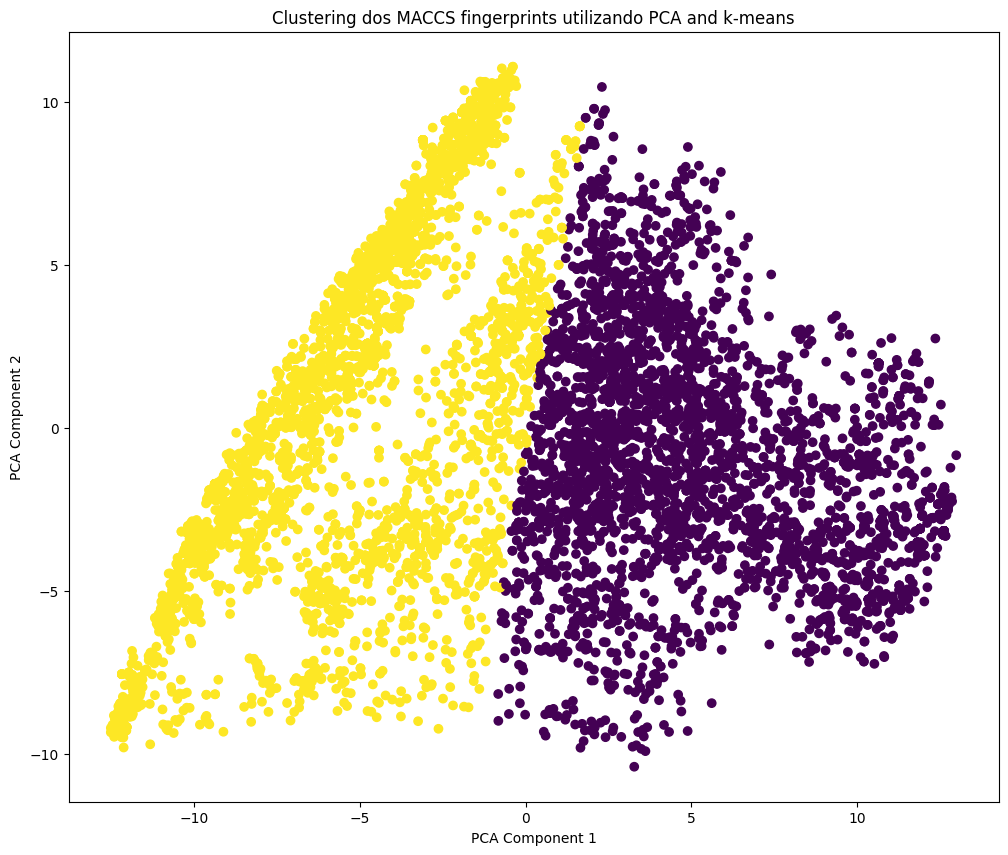

In [33]:
# Realiza o k-means clustering com k=3
kmeans = KMeans(n_clusters=2, random_state=0).fit(pca_data)
labels = kmeans.labels_
plt.figure(figsize=(12, 10))
plt.scatter(pca_data[:, 0], pca_data[:, 1], c=labels, cmap='viridis')
plt.title('Clustering dos MACCS fingerprints utilizando PCA and k-means')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.show()

### PubChem Fingerprinting
</p>
<div style="text-align: justify">
O sistema PubChem tem como função a criação de uma subestrutura binária 'fingerprint' para esturuturas químicas. Estas 'fingerprints' são usadas na base de dados PubChem para a procura de similariedade entre vizinhos e na pesquisa. </div>
</p>
<div style="text-align: justify">
Cada fragmento de uma estrutura química é representado pela substrutura. O 'fingerprint' é uma lista binária (bits) ordenada (1 ou 0). Cada bit representa a determinação boleana para a presença de uma característica química estrutural.</div>
</p>
<div style="text-align: justify">
Neste momento PubChem fingerprints tem 881 bits, armazenando 880 características estruturais.</div> 

In [34]:
# gera as representações de PubChem Fingerprinting
mol = df['ROMol']
df['ap_fingerprint'] = df['ROMol'].apply(lambda mol: GetHashedAtomPairFingerprintAsBitVect(mol))
df['tt_fingerprint'] = df['ROMol'].apply(lambda mol: GetHashedTopologicalTorsionFingerprintAsBitVect(mol))

# exibe as representações de PubChem Fingerprinting
print('Atom Pair Fingerprint:')
print(df['ap_fingerprint'])

print('Topological Torsion Fingerprint:')
print(df['tt_fingerprint'])

Atom Pair Fingerprint:
0       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
1       [1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, ...
2       [0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, ...
3       [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
4       [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
                              ...                        
7268    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
7269    [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
7270    [1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
7271    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
7272    [0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, ...
Name: ap_fingerprint, Length: 7273, dtype: object
Topological Torsion Fingerprint:
0       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, ...
1       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
2       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, ...
3       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
4       [0, 0, 0, 0, 0, 

#### Análise dos Componentes Principais (PCA)

In [35]:
# Criar uma matriz a partir dos fingerprints
ap_fps = np.array([np.frombuffer(bytes(fp.ToBitString(), 'utf-8'), dtype=np.uint8) for fp in df['ap_fingerprint']])
tt_fps = np.array([np.frombuffer(bytes(fp.ToBitString(), 'utf-8'), dtype=np.uint8) for fp in df['tt_fingerprint']])

# Padronizar os dados
ap_fps = StandardScaler().fit_transform(ap_fps)
tt_fps = StandardScaler().fit_transform(tt_fps)

In [36]:
# Aplicar PCA aos dados padronizados

pca = PCA(n_components=2)
ap_pca = pca.fit_transform(ap_fps)
tt_pca = pca.fit_transform(tt_fps)

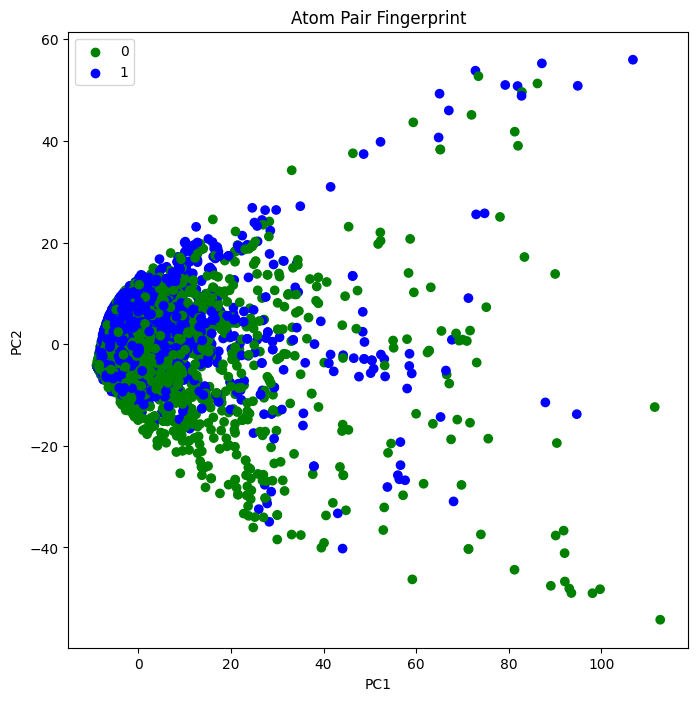

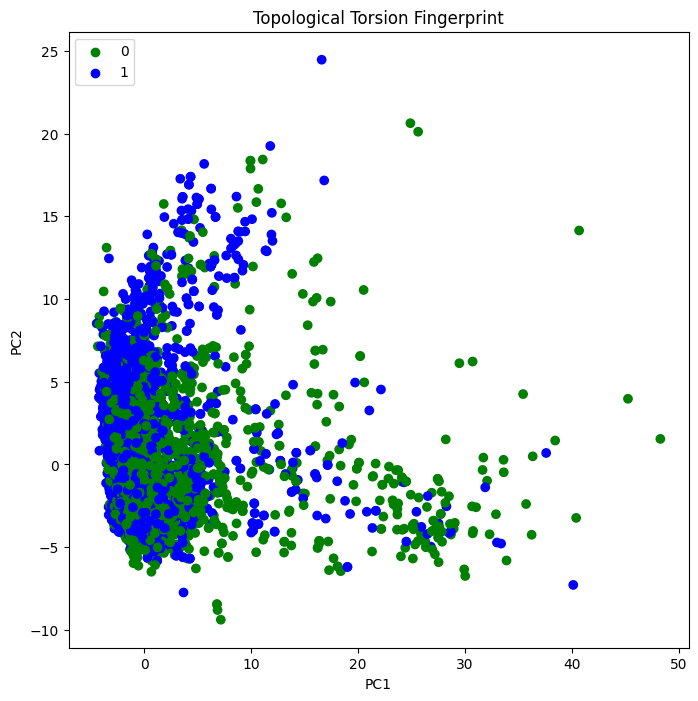

In [37]:
%matplotlib inline
# mapa de cores para o plot
data_colors = {0: 'green', 1: 'blue'}
colors = [data_colors[t] for t in df['Y']]

# plot
plt.figure(figsize=(8, 8))
plt.scatter(ap_pca[:, 0], ap_pca[:, 1], c=colors)
plt.title('Atom Pair Fingerprint')
plt.xlabel('PC1')
plt.ylabel('PC2')

# legenda
handles = []
labels = []
for data_type, color in data_colors.items():
    handles.append(plt.scatter([], [], c=color))
    labels.append(data_type)# legenda
plt.legend(handles, labels, loc='upper left')

plt.figure(figsize=(8, 8))
plt.scatter(tt_pca[:, 0], tt_pca[:, 1], c=colors)
plt.title('Topological Torsion Fingerprint')
plt.xlabel('PC1')
plt.ylabel('PC2')

# legenda
handles = []
labels = []
for data_type, color in data_colors.items():
    handles.append(plt.scatter([], [], c=color))
    labels.append(data_type)# legenda
plt.legend(handles, labels, loc='upper left')


### 

### Split do dataset de acordo com as similiariedades

</p>
<div style="text-align: justify">
De modo a definir o 'test set' recorreu-se à clusterização por similaridade em que se atribuiu instâncias de cada cluster de forma equilibrada, garantindo que cada conjunto contenha uma representação adequada de diferentes padrões presentes nos dados.
Deste modo, implementou-se a  função chamada 'generate_similarities', que calcula as similaridades entre moléculas representadas por SMILES usando Morgan fingerprints. Em seguida, realizou-se uma redução de dimensionalidade usando o t-SNE, seguido do algoritmo K-means para clusterizar os dados de similaridade reduzidos.</div>

In [38]:
def generate_similarities(smiles):
    fps = []
    similarities_list = []
    for smiles in smiles:
        fp = AllChem.GetMorganFingerprintAsBitVect(Chem.MolFromSmiles(smiles), 2, 2048)
        fps.append(fp)
    
    if len(fps) > 10000:
        entries = 10000
    else:
        entries = len(fps)
        
    for i in range(0,entries):
        
        remaining_fp = fps[:i] + fps[i+1:]
        similarities = DataStructs.BulkTanimotoSimilarity(fps[i], remaining_fp)
        similarities.insert(i,1)
        similarities_list.append(similarities)
        
    return np.transpose(np.array(similarities_list))

In [39]:
np.random.seed(42)
similaridades=generate_similarities(df.smiles)

In [40]:
# generate tSNE latent space of molecular similarities
tsne_similarities = TSNE(n_components=2,random_state=42).fit_transform(similaridades)

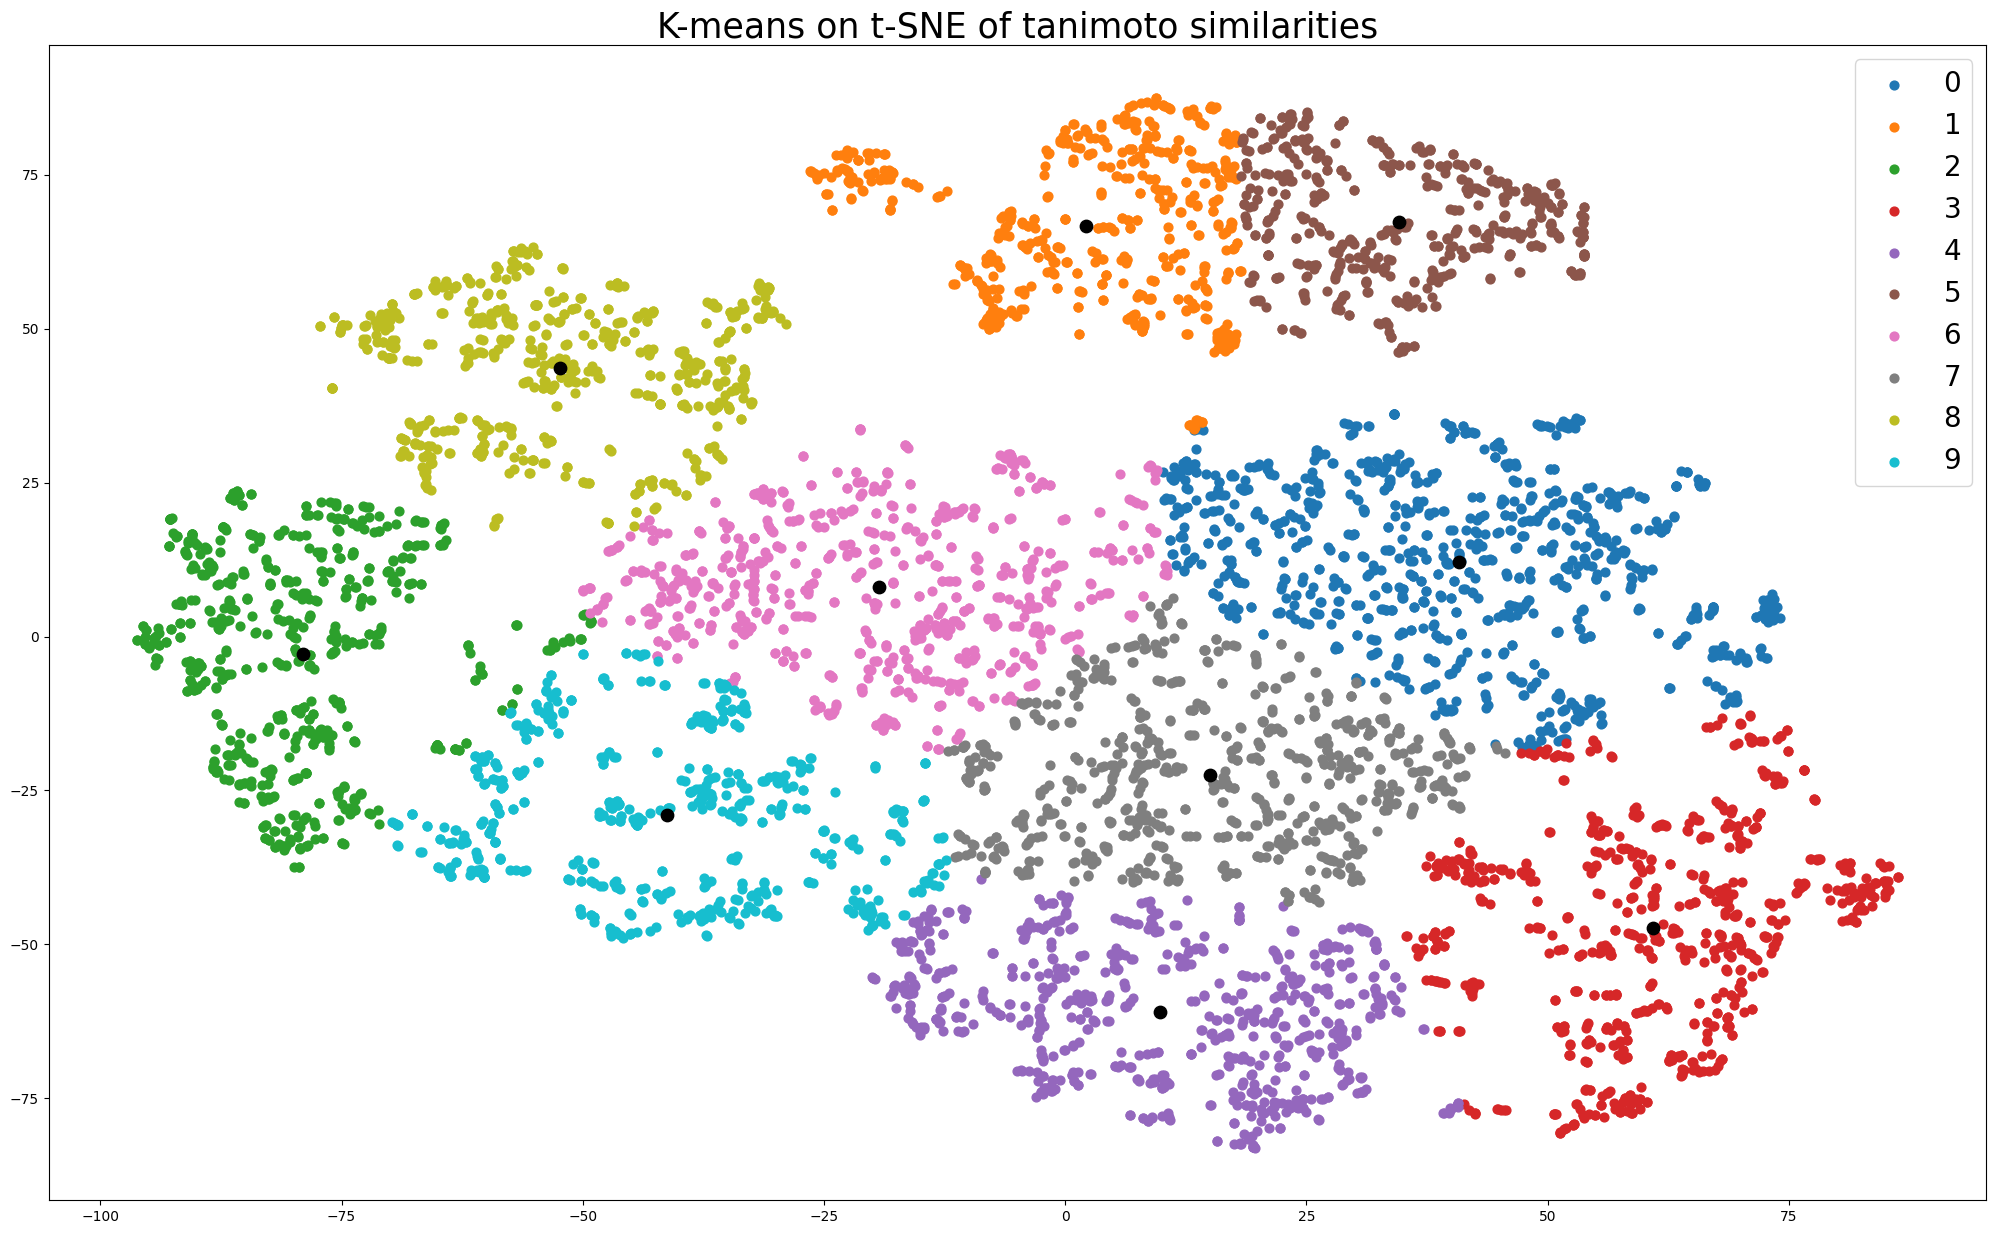

In [41]:
kmeans = KMeans(n_clusters=10,random_state=42).fit(tsne_similarities)
u_labels = np.unique(kmeans.labels_)
plt.subplots(1, figsize=(25, 15))
# plotting the results:
centroids = kmeans.cluster_centers_
for i in u_labels:
    plt.scatter(tsne_similarities[kmeans.labels_ == i, 0], tsne_similarities[kmeans.labels_ == i, 1], label=i, s=40)
plt.scatter(centroids[:, 0], centroids[:, 1], s=80, color='k')
plt.legend(prop={'size': 20})
plt.title("K-means on t-SNE of tanimoto similarities", fontsize=25)
plt.show()

In [42]:
df['kmeans'] = kmeans.labels_

In [43]:
df.columns

Index(['ids', 'smiles', 'Y', 'ROMol', 'MFP', 'MFP_array', 'TSNE_C1', 'TSNE_C2',
       'pc1', 'pc2', 'pc3', 'tsne_pca1', 'tsne_pca2', 'maccs',
       'ap_fingerprint', 'tt_fingerprint', 'kmeans'],
      dtype='object')

In [44]:
df_ml=df[['ids', 'Y', 'MFP_array', 'maccs', 'ap_fingerprint', 'tt_fingerprint','kmeans']]
df_ml.columns

Index(['ids', 'Y', 'MFP_array', 'maccs', 'ap_fingerprint', 'tt_fingerprint',
       'kmeans'],
      dtype='object')

</p>
<div style="text-align: justify">
 Tendo em conta a distribuição dos dados pelos 10 clusters, definiu-se a função 'create_subset_clusters' que permiti obter o subset equilibrado, uma vez que foram adicionados compostos químicos de todos clusters ordenados até obter um subset com 15% dos dados. Assim, a função retornou o 'test set' e o dataframe original sem os dados selecionados para o 'test set'.</div>

In [45]:
def create_subset_clusters(df, u_labels, per_dec):
    test_set = pd.DataFrame()
    df_sem_subset = df.copy()

    for i in range(int(per_dec * len(df))):
        cluster = u_labels[i % len(u_labels)]
        sub_sf = df_sem_subset.loc[df_sem_subset['kmeans'] == cluster]
        row = sub_sf.sample(n=1,random_state=42)
        df_sem_subset = df_sem_subset.drop(row.index)
        test_set = pd.concat([test_set, row], ignore_index=True)

    return test_set, df_sem_subset

In [46]:
np.random.seed(42)
test_set_final, df_sem_testset = create_subset_clusters(df_ml, u_labels, 0.15)

In [47]:
df_sem_testset.shape

(6183, 7)

In [48]:
test_set_final.shape

(1090, 7)

 </p>
<div style="text-align: justify">
  O próximo passo consistiu em obter o 'validation set' que será posteriormente implementado nos modelos de DL. Em que se aplicou a mesma função, com intuito de obter outro subset com 15% dos dados. Além disso, retornou-se o 'train set' que corresponde a 70 % dos compostos químicos.</div>

In [49]:
np.random.seed(42)
validation_set, train_set = create_subset_clusters(df_sem_testset, u_labels, 0.1763)

In [50]:
train_set.shape
train_set.columns
train_set

,ids,Y,MFP_array,maccs,ap_fingerprint,tt_fingerprint,kmeans
0,Drug 0,1,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, ...",5
1,Drug 1,1,"[0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",5
2,Drug 2,0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, ...",4
3,Drug 3,1,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",8
4,Drug 4,1,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",9
...,...,...,...,...,...,...,...
7268,Drug 7587,0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",2
7269,Drug 7588,0,"[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, ...",7
7270,Drug 7593,0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, ...",7
7271,Drug 7598,0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",6


In [51]:
#construir o mesmos datasets mas com os descriptors de cada molecula
train_set_descriptors = df_features.loc[train_set.index]
train_set_descriptors['Y'] = train_set['Y']

validation_set_descriptors = df_features.loc[validation_set.index]
validation_set_descriptors['Y'] = validation_set['Y']

test_set_descriptors = df_features.loc[test_set_final.index]
test_set_descriptors['Y'] = test_set_final['Y']

train_set_descriptors

,MaxEStateIndex,MinEStateIndex,MaxAbsEStateIndex,MinAbsEStateIndex,qed,MolWt,HeavyAtomMolWt,ExactMolWt,NumValenceElectrons,NumRadicalElectrons,...,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea,Y
0,11.663401,-0.396099,11.663401,0.008895,0.181963,342.310,332.230,342.06406,124.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
1,11.824743,-0.170602,11.824743,0.170602,0.269289,301.345,286.225,301.11030,112.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
2,14.431072,-0.378575,14.431072,0.128988,0.184582,646.614,628.470,646.11650,232.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
3,10.422196,-0.670278,10.422196,0.248657,0.103849,157.133,150.077,157.05997,60.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
4,10.521759,-0.752407,10.521759,0.278148,0.342148,138.086,136.070,138.01778,50.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7268,8.502606,0.150556,8.502606,0.150556,0.485970,230.392,200.152,230.22458,98.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,11.0,0.0,0
7269,2.303843,0.640191,2.303843,0.640191,0.700283,210.320,192.176,210.14085,82.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
7270,5.671445,-1.672137,5.671445,0.713245,0.722425,246.337,231.217,246.03020,78.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
7271,10.862176,-0.203597,10.862176,0.038935,0.498826,194.274,176.130,194.13068,78.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0


In [52]:
validation_set.shape

(1090, 7)

In [53]:
test_set_final['subset'] =['test']*len(test_set_final)
validation_set['subset'] =['validation']*len(validation_set)
train_set['subset'] =['train']*len(train_set)

In [54]:
set_df = pd.concat([test_set_final,validation_set,train_set])
set_df.shape

(7273, 8)

 </p>
<div style="text-align: justify">
De seguida recorreu-se à representação gráfica dos clusters tendo em conta a distinção dos 'subsets', em que se verificou uma distribuição equilibrada dos dados tanto no 'test set' como 'validation set' como esperado. </div>

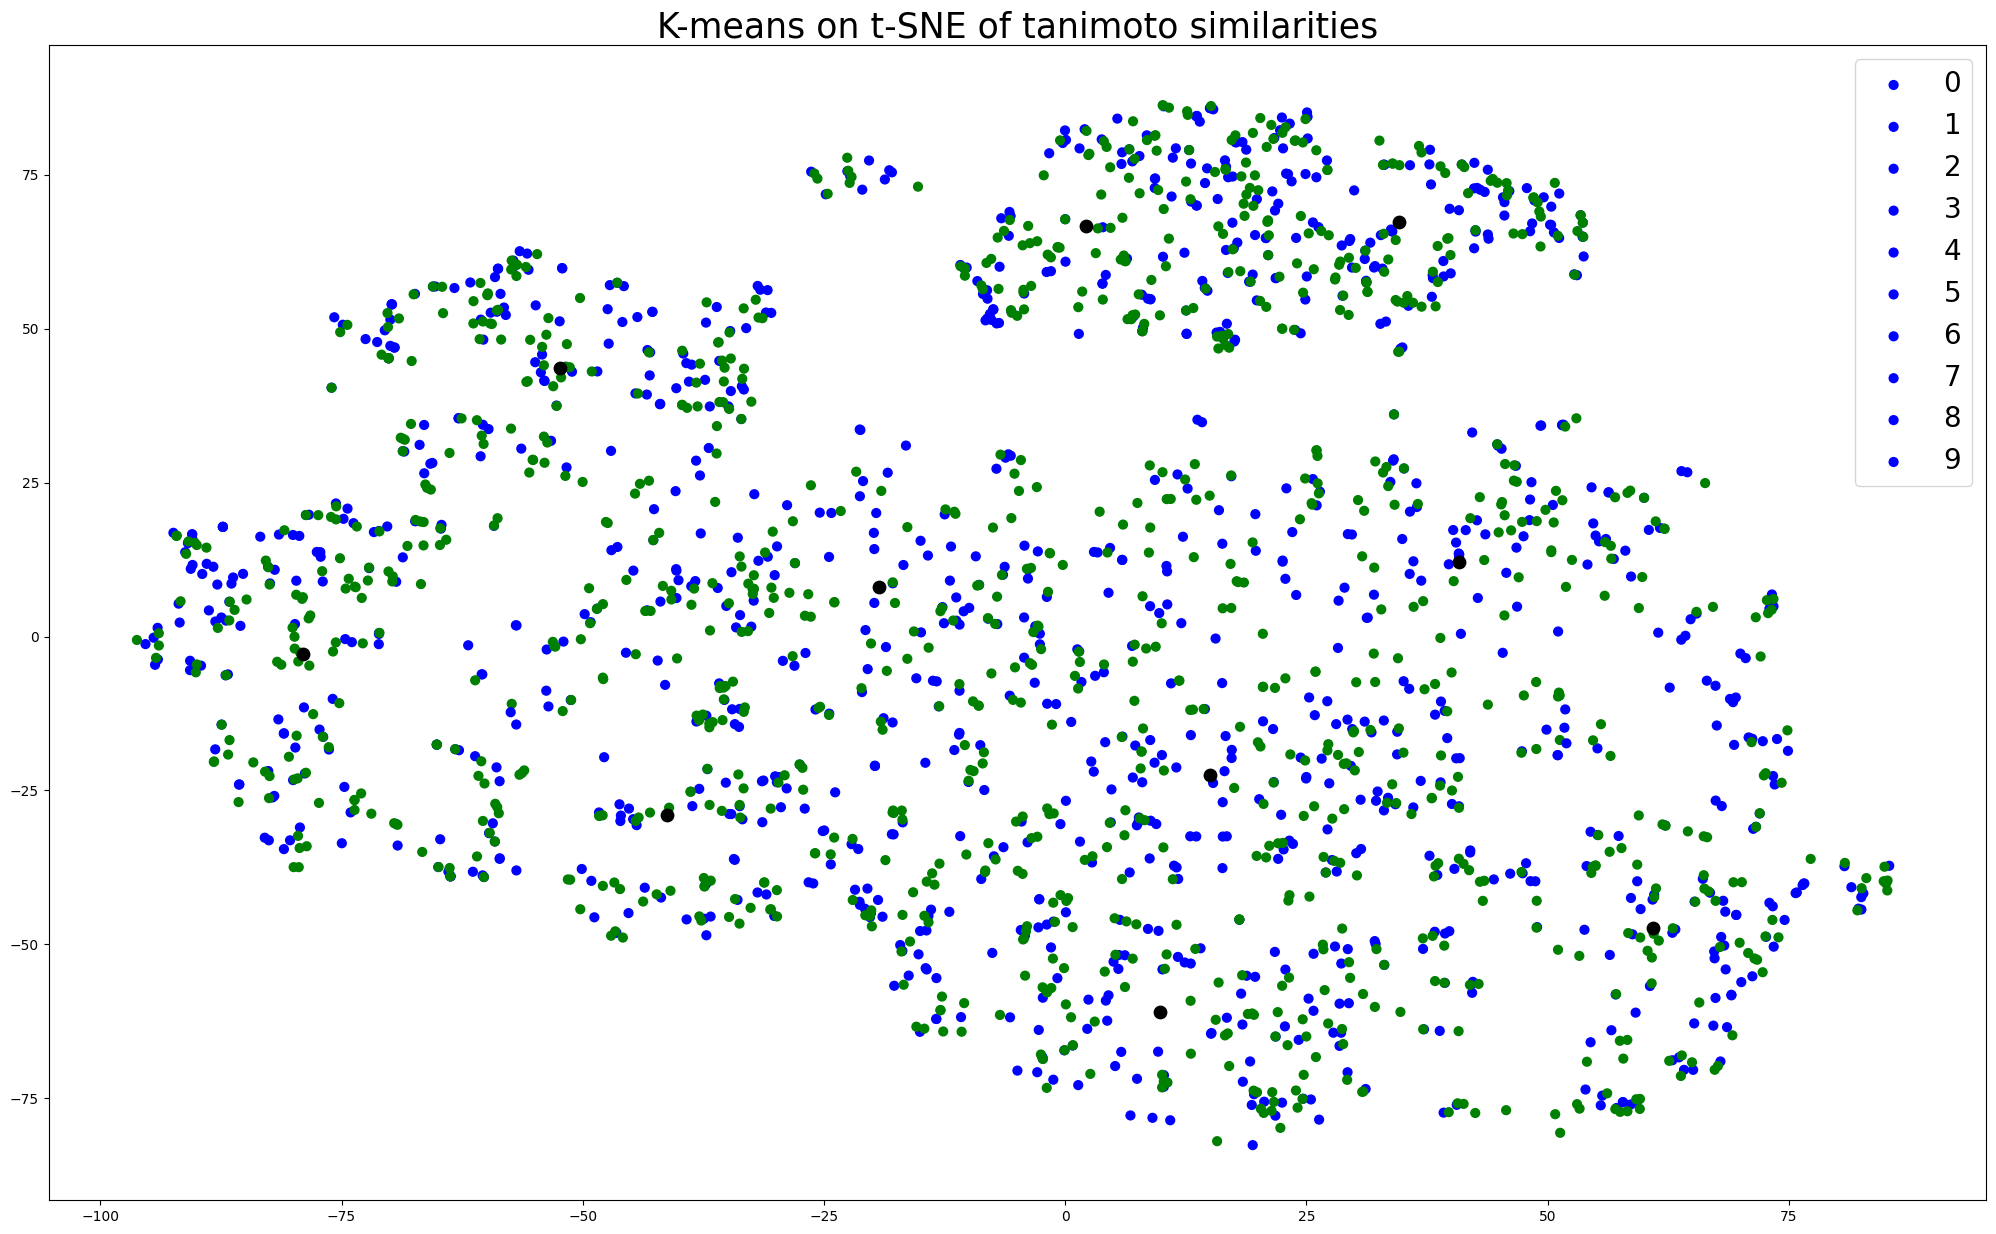

In [45]:
# Define o mapeamento de cores personalizado
color_mapping = {'test': 'blue', 'validation': 'green', 'train': 'none'}

plt.subplots(1, figsize=(25, 15))
for i in u_labels:
    subset_colors = [color_mapping[x] for x in set_df.loc[set_df['kmeans'] == i, 'subset']]
    plt.scatter(tsne_similarities[kmeans.labels_ == i, 0], tsne_similarities[kmeans.labels_ == i, 1],
                label=i, s=40, c=subset_colors)
plt.scatter(centroids[:, 0], centroids[:, 1], s=80, color='k')
plt.legend(prop={'size': 20})
plt.title("K-means on t-SNE of tanimoto similarities", fontsize=25)
plt.show()

## Machine Learning (ML)
<p>
<div style="text-align: justify">
A previsão da mutagenicidade é um aspecto crucial no campo da toxicologia e na avaliação de riscos ambientais e de saúde humana. O teste Ames, um dos métodos mais amplamente utilizados para a detecção de mutagenicidade em compostos químicos, tem sido uma ferramenta fundamental para avaliar o potencial de substâncias em causar danos genéticos. No entanto, a aplicação tradicional desse teste pode ser trabalhosa.</div>
</p>
<div style="text-align: justify">
Nesse contexto, constuiu-se um conjunto de modelos machine learning com o objetivo de prever a mutagenicidade dos compostos, tanto através dos fingerprints representativos de cada um, bem como dos seus descriptors. No total optou-se por realizar 3 modelos de ML, sendo eles SVM(Support Vector Machine), KNN(k-Nearest Neighbors) e Naive Bayes.

 #### Modelo SVM 
<p>
<div style="text-align: justify">
O SVM é um algoritmo de Machine Learning que mapeia os dados em um espaço de alta dimensão e cria um hiperplano otimizado para separar as diferentes classes. O SVM tem sido amplamente aplicado em diversos campos, incluindo a toxicologia e a previsão de mutagenicidade no teste Ames.
</div>
</p>
<div style="text-align: justify">
Na literatura, vários estudos têm explorado o uso do SVM na previsão da mutagenicidade em testes Ames [3-7]. Por exemplo, Chu, C. et al. (2021) utilizaram um conjunto de dados contendo descritores moleculares para treinar um modelo SVM e obter uma classificação precisa de compostos como mutagénicos ou não mutagénicos, em que os resultados obtidos demonstraram que o SVM alcançou uma alta sensibilidade e especificidade na previsão da mutagenicidade [6].
</div>
</p>
<div style="text-align: justify">
Além disso, Xu, C, et al. (2012) investigaram a eficácia do SVM em comparação com outros métodos de Machine Learning na classificação da mutagenicidade. O estudo consistiu em constriur um dataset contendo 7617 compostos diversos, incluindo 4252 mutagénicos e 3365 não mutagénicos. Com base nesse conjunto de dados, foram desenvolvidos modelos preditivos utilizando vários métodos de Machine Learning juntamente com cinco tipos de descritores moleculares: CDK fingerprint (FP), Estate fingerprint (Estate), MACCS keys (MACCS), PubChem fingerprint (PubChem) e Substructure fingerprint (SubFP) [5]. 

</div>
</p>
No caso do presente trabalho, optamos por uma abordagem semelhante, devido à similariedade do tipo de dados.


In [56]:
# Converter as listas de fingerprints em uma matriz NumPy
train_set_valid = pd.concat([train_set,validation_set])
y_train = train_set_valid['Y']
fingerprints = ['MFP_array','maccs','ap_fingerprint','tt_fingerprint']
Xs_train = []
Xs_test = []
for fp in fingerprints:
    Xs_train.append(np.array(train_set_valid[fp].tolist()))
    Xs_test.append(np.array(test_set_final[fp].tolist()))



In [47]:
from model_util import svm

svm(fingerprints, Xs_train, Xs_test, y_train, test_set_final, train_set_descriptors, test_set_descriptors)
    

##### MFP_array #####
              precision    recall  f1-score   support

           0       0.76      0.80      0.78       456
           1       0.85      0.82      0.84       634

    accuracy                           0.81      1090
   macro avg       0.81      0.81      0.81      1090
weighted avg       0.81      0.81      0.81      1090

Confusion Matrix (MFP_array) :
[[364  92]
 [113 521]]

Cross-Validation Accuracy (MFP_array) : 76.82%
MCC (MFP_array) : 0.62
Fowlkes-Mallows Index (MFP_array) : 0.84
Bookmaker Informedness (MFP_array) : 0.62
DeltaP (MFP_array) : 0.27

##########################################################

##### maccs #####
              precision    recall  f1-score   support

           0       0.75      0.67      0.71       456
           1       0.78      0.84      0.81       634

    accuracy                           0.77      1090
   macro avg       0.76      0.75      0.76      1090
weighted avg       0.77      0.77      0.76      1090

Confusion M

 </p>
<div style="text-align: justify">
A métrica 'accuracy' indica a proporção de exemplos classificados corretamente em relação ao total de exemplos. No entanto, é influencida em casos de conjuntos de dados desequilibrados. 
Relativamente ao valor da métrica 'accuracy', a fingerprint MFP apresenta valores mais elevados, com 81%. Contudo, o valor da métrica é muito semelhante para todos os modelos.</div>
</p>
<div style="text-align: justify">
A matriz de confusão é uma tabela que mostra as previsões realizadas pelo modelo em relação aos valores verdadeiros de cada label. Fornece informações mais detalhadas sobre os resultados do modelo, permitindo calcular outras métricas, como precisão, recall e F1-score.
Assim sendo, todas as fingerprints apresentam matrizes de confusão semerlhantes, no entanto, continua a ser a fingerprint MFP a apresentar os melhores resultados com 92 falsos positivos e 113 falsos negativos.
</div>
</p>
<div style="text-align: justify">
Será importante também referir que é necessário ter em conta a importância relativa de cada tipo de erro (falsos positivos versus falsos negativos). Como estamos a avaliar a mutagenicidade de compostos químicos, com vista à sua implementação na indústria farmacêutica, alimentar, entre outras, seria mais prudente obter maior número de falsos positivos.</div>



O F1 Score é uma métrica que combina a precisão e recall num único valor, indicando o equilíbrio entre eless. Neste caso, todas as fingerprints apresentam um F1 Score médio razoável, indicando um bom equilíbrio entre precisão e recall.

O MCC (Matthews Correlation Coefficient) é uma métrica que avalia a qualidade geral das previsões do modelo, considerando todos os elementos da matriz de confusão. Nesse caso, a fingerprint com melhor desempenho continua a ser a MFP, com um MCC score de 0.62.

O Fowlkes-Mallows Index é uma métrica que mede a similaridade entre dois grupos, permitindo avaliar a concordância entre os valores reais e os previstos pelo modelo. Com um score de 0.84, é novamente a fingerprint MFP que obtém os melhores resultados, indicando uma boa concordância entre os valores reais e previstos.

O Bookmaker Informedness é uma métrica que combina a taxa de verdadeiros positivos e a taxa de verdadeiros negativos, oferecendo uma avaliação do desempenho do modelo na distinção entre classes. Em relação a essa métrica, com um score de 0.62, mais uma vez a fingerprint MFP apresenta os melhores resultados.

O DeltaP é uma métrica que mede a diferença proporcional entre verdadeiros positivos e falsos positivos. Nesse caso, todas as fingerprints obtêm resultados semelhantes, com a fingerprint MFP a obter um delta P de 0.27. No entanto, esses valores são baixos, o que implica uma maior dificuldade do modelo em reduzir os falsos positivos.

Resumindo, todas as fingerprints apresentam resultados semelhantes. No entanto, a fingerprint MFP destaca-se em todas as métricas mencionadas. 

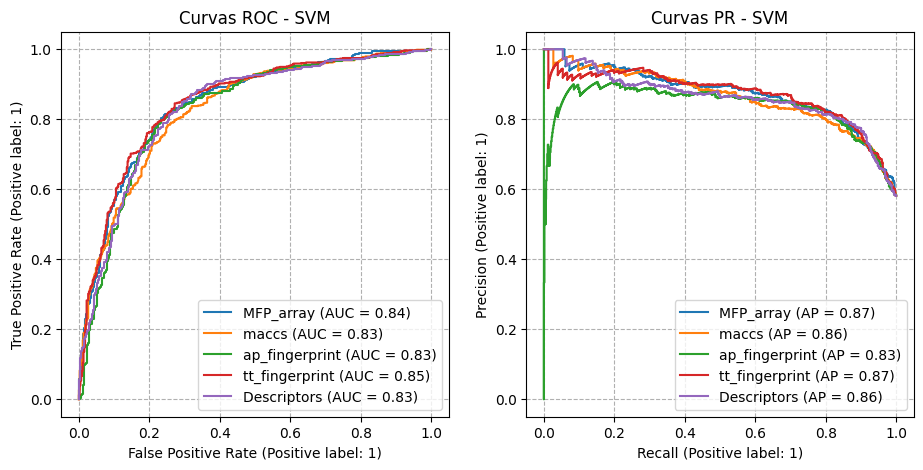

In [48]:
from model_util import svm_curves

svm_curves(fingerprints, train_set_descriptors, test_set_descriptors, Xs_train, Xs_test, y_train, test_set_final)

A AUC-ROC (Área sob a Curva ROC) é uma métrica de avaliação amplamente utilizada para modelos de classificação binária. A curva ROC (Receiver Operating Characteristic) representa a taxa de verdadeiros positivos (TPR) em função da taxa de falsos positivos (FPR) para diferentes thresholds. Para os modelos em análise, os valores de AUC (Área sob a Curva ROC) variam entre 0.83 e 0.85 o que é indicativo de um bom desempenho do modelo de classificação. A AUC é uma métrica que varia de 0 a 1, onde um valor de 0.5 indica um desempenho aleatório e um valor de 1 indica um desempenho perfeito.

O mesmo aplica-se às Curvas PR, no entanto estas curvas representam a relação entre a precisão eo recall para diferentes thresholds. Também aqui se nota um equilibrio entre todos os fingerprints.

### K-Nearest Neighbors

O K-Nearest Neighbors (KNN) é baseado no princípio de que as instâncias semelhantes estarão próximas umas das outras no espaço de features. O algoritmo faz as suas classificações/previsões ao atribuindo labels às instâncias de teste com base nas labels das instâncias vizinhas mais próximas. A instância mais próxima pode ser calculada através de distância Euclideana ou de Manhattan, por exemplo.

In [49]:
from model_util import knn

knn(fingerprints, Xs_train, Xs_test, y_train, test_set_final, train_set_descriptors, test_set_descriptors)

##### MFP_array #####
              precision    recall  f1-score   support

           0       0.79      0.79      0.79       456
           1       0.85      0.85      0.85       634

    accuracy                           0.82      1090
   macro avg       0.82      0.82      0.82      1090
weighted avg       0.82      0.82      0.82      1090

Confusion Matrix (MFP_array) :
[[361  95]
 [ 96 538]]

Cross-Validation Accuracy (MFP_array) : 79.43%
MCC (MFP_array) : 0.64
Fowlkes-Mallows Index (MFP_array) : 0.85
Bookmaker Informedness (MFP_array) : 0.64
DeltaP (MFP_array) : 0.27

##########################################################

##### maccs #####
              precision    recall  f1-score   support

           0       0.79      0.76      0.77       456
           1       0.83      0.85      0.84       634

    accuracy                           0.81      1090
   macro avg       0.81      0.81      0.81      1090
weighted avg       0.81      0.81      0.81      1090

Confusion M

Também nos modelos KNN os resultados são equilibrados para todas as fingerprints. 

No entanto, é importante notar que neste caso também os descritores moleculares poderão apresentar vantagens relativamente à utilização de fingerprints. Neste caso, os descritores destacam-se em praticamente todas as métricas analisadas

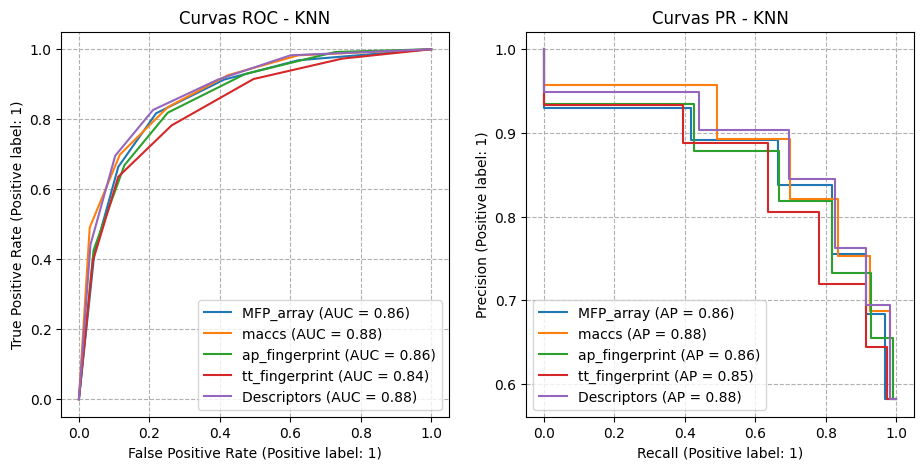

In [50]:
from model_util import knn_curves

knn_curves(fingerprints, train_set_descriptors, test_set_descriptors, Xs_train, Xs_test, y_train, test_set_final)

Para os modelos em análise, os valores de AUC-ROC variam entre 0.84 e 0.88 o que é indicativo de um bom desempenho do modelo de classificação. Comparativamente aos modelos SVM, os estes valores são até ligeiramente superiores.
O mesmo aplica-se às Curvas PR, onde também aqui se nota um equilibrio entre todos os modelos.

### Naive Bayes

O Naive Bayes é um algoritmo de machine learning baseado no teorema de Bayes. Assume uma independência condicional entre as features, o que significa que cada feature é tratada como sendo independente das outras.

In [57]:
from model_util import naive_bayes

naive_bayes(fingerprints, Xs_train, Xs_test, y_train, test_set_final, train_set_descriptors, test_set_descriptors)

##### MFP_array #####
              precision    recall  f1-score   support

           0       0.64      0.74      0.69       456
           1       0.79      0.70      0.74       634

    accuracy                           0.72      1090
   macro avg       0.72      0.72      0.71      1090
weighted avg       0.73      0.72      0.72      1090

Confusion Matrix (MFP_array) :
[[338 118]
 [190 444]]

Cross-Validation Accuracy (MFP_array) : 72.13%
MCC (MFP_array) : 0.44
Fowlkes-Mallows Index (MFP_array) : 0.74
Bookmaker Informedness (MFP_array) : 0.44
DeltaP (MFP_array) : 0.21

##########################################################

##### maccs #####
              precision    recall  f1-score   support

           0       0.60      0.70      0.65       456
           1       0.75      0.67      0.71       634

    accuracy                           0.68      1090
   macro avg       0.68      0.68      0.68      1090
weighted avg       0.69      0.68      0.68      1090

Confusion M

Também nos modelos Naive Bayes os resultados são equilibrados para todas as fingerprints. 

Apesar de os valores serem equilibrados, concluimos que os modelos Naive Bayes poderão não ser a melhor opção a ser utilizada neste tipo de casos. Todas as métricas utilizadas (independentemente da fingerprint) são inferiores aos modelos SVM e KNN, na sua generalidade

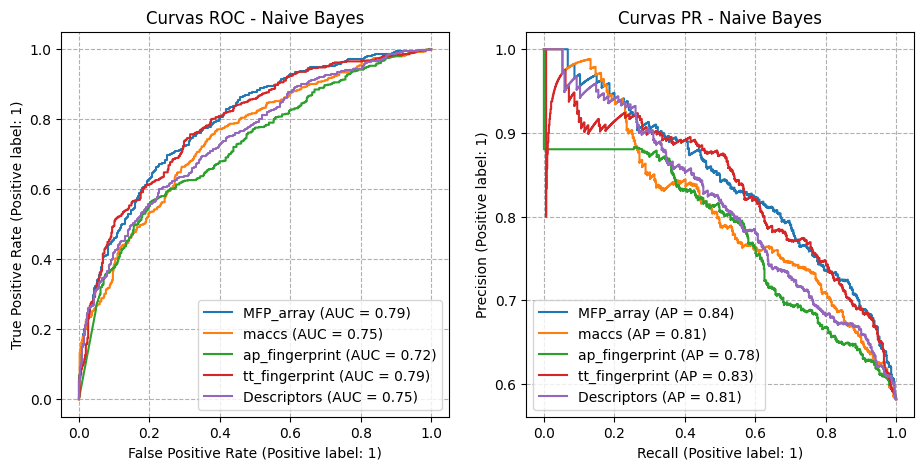

In [ ]:
from model_util import naive_bayes_curves

naive_bayes_curves(fingerprints, train_set_descriptors, test_set_descriptors, Xs_train, Xs_test, y_train, test_set_final)

Também nas curvas ROC e PR se nota um equilibrio nos resultados, mas ainda assim inferiores aos modelos SVM e KNN

## Deep Learning

No mesmo seguimento, as técnicas de deep learning têm ganho destaque como abordagens promissoras para a previsão rápida e precisa da mutagenicidade, oferecendo uma alternativa eficiente aos métodos tradicionais.

Os modelos de deep learning são redes neuronais artificiais compostas por múltiplas camadas, que permitem a extração de representações complexas e hierárquicas dos dados. Estas redes são capazes de aprender automaticamente padrões e características relevantes dos compostos químicos, recolhendo informações presentes em conjuntos de dados. Com o avanço da disponibilidade de dados moleculares e o aumento do poder computacional, os modelos de deep learning têm sido amplamente explorados para a previsão da mutagenicidade [8-11].

Na literatura científica, vários estudos têm demonstrado a eficácia dos modelos de deep learning na previsão da mutagenicidade. Por exemplo, Kumar, R. et al. (2021) desenvolveram um classificador baseado em DNN e verificaram que para além de se ajustar aos dados com melhor desempenho em comparação com os algoritmos tradicionais de aprendizado de máquina, também produz métricas de desempenho melhores [9].

Além disso, Hung, C. et al. (2021) exploraram o uso de redes neurais convolucionais (CNNs) para a previsão da mutagenicidade, sem o uso de descriptores. Eles utilizaram estruturas tridimensionais de compostos químicos como entrada para a rede, capturando informações espaciais e estruturais relevantes. Os resultados obtidos indicaram que as CNNs alcançaram uma precisão significativa na classificação dos compostos testados, destacando a capacidade desses modelos em aprender características específicas relacionadas com a mutagenicidade [11].

### Redes neurais convolucionais (CNNs)

As redes neuronais convolucionais (CNNs) são um tipo especializado de arquitetura de rede neuronal frequentemente utilizadas em tarefas de processamento de imagens. Destacam-se pela capacidade de extrair características relevantes de forma automática a partir dos dados de entrada. As CNNs são compostas por camadas convolucionais, camadas de pooling e camadas totalmente conectadas, que trabalham em conjunto para realizar a aprendizagem e classificação de padrões nas imagens [10,11].

Na previsão da mutagenicidade, as CNNs têm sido exploradas para analisar estruturas moleculares em três dimensões ou representações 2D, como as fórmulas de estrutura plana simplificada (SMILES). Ao aplicar as CNNs em problemas de mutagenicidade, as camadas convolucionais são responsáveis por detectar características moleculares relevantes, como grupos funcionais ou arranjos moleculares específicos. Estas informações são então processadas pelas camadas de pooling para reduzir a dimensionalidade e extrair as características. Por fim, as camadas totalmente conectadas são utilizadas para a classificação final dos compostos em mutagénicos ou não mutagénicos [11].


### MFP fingerprint - CNNs

In [223]:
train_set.columns

Index(['ids', 'Y', 'MFP_array', 'maccs', 'ap_fingerprint', 'tt_fingerprint',
       'kmeans', 'subset'],
      dtype='object')

In [224]:
test_set_final.columns

Index(['ids', 'Y', 'MFP_array', 'maccs', 'ap_fingerprint', 'tt_fingerprint',
       'kmeans', 'subset'],
      dtype='object')

In [225]:
validation_set.columns
y_val = validation_set["Y"].values
y_test = test_set_final["Y"].values
y_train = train_set["Y"].values

In [226]:
x_train_mfp = train_set["MFP_array"].values
test_mfp = test_set_final["MFP_array"].values
val_mfp = validation_set["MFP_array"].values

In [227]:
converted_data_mfp = np.empty((x_train_mfp.shape[0], 1024), dtype=np.float32) # Convert each list in the original data to a numpy array 
for i, row in enumerate(x_train_mfp): converted_data_mfp[i] = np.array(row, dtype=np.float32) 
test_mfp_converted = np.empty((test_mfp.shape[0], 1024), dtype=np.float32) # Convert each list in the original data to a numpy array 
for i, row in enumerate(test_mfp): test_mfp_converted[i] = np.array(row, dtype=np.float32) 
val_mfp_converted = np.empty((val_mfp.shape[0], 1024), dtype=np.float32) # Convert each list in the original data to a numpy array 
for i, row in enumerate(val_mfp): val_mfp_converted[i] = np.array(row, dtype=np.float32) 

In [231]:
model_mfp_cnn = Sequential()
model_mfp_cnn.add(Conv1D(32, kernel_size=3, activation='relu', input_shape=(1024, 1)))
model_mfp_cnn.add(MaxPooling1D(pool_size=2))
model_mfp_cnn.add(Conv1D(64, kernel_size=3, activation='relu'))
model_mfp_cnn.add(MaxPooling1D(pool_size=2))
model_mfp_cnn.add(Flatten())
model_mfp_cnn.add(Dense(64, activation='relu'))
model_mfp_cnn.add(Dense(1, activation='sigmoid'))

model_mfp_cnn.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

checkpoint = ModelCheckpoint("mfp_cnn.h5", monitor='val_loss', save_best_only=True, mode='min')

mfp_cnn = model_mfp_cnn.fit(converted_data_mfp,y_train,validation_data=(val_mfp_converted, y_val),epochs=10, batch_size=32, callbacks=[checkpoint])

Epoch 1/10
160/160 [==============================] - 6s 32ms/step - loss: 0.5562 - accuracy: 0.7139 - val_loss: 0.4863 - val_accuracy: 0.7697
Epoch 2/10
160/160 [==============================] - 5s 31ms/step - loss: 0.4448 - accuracy: 0.7913 - val_loss: 0.4591 - val_accuracy: 0.7862
Epoch 3/10
160/160 [==============================] - 5s 31ms/step - loss: 0.3627 - accuracy: 0.8423 - val_loss: 0.4532 - val_accuracy: 0.7936
Epoch 4/10
160/160 [==============================] - 5s 30ms/step - loss: 0.2682 - accuracy: 0.8910 - val_loss: 0.5116 - val_accuracy: 0.7890
Epoch 5/10
160/160 [==============================] - 5s 31ms/step - loss: 0.1963 - accuracy: 0.9297 - val_loss: 0.5663 - val_accuracy: 0.8073
Epoch 6/10
160/160 [==============================] - 5s 30ms/step - loss: 0.1311 - accuracy: 0.9531 - val_loss: 0.6491 - val_accuracy: 0.8000
Epoch 7/10
160/160 [==============================] - 5s 31ms/step - loss: 0.0894 - accuracy: 0.9707 - val_loss: 0.7611 - val_accuracy: 0.7872

In [61]:
model_mfp_cnn.load_weights('mfp_cnn.h5')


Em resumo, estes resultados indicam que o modelo está a melhorar à medida que o treino avança. Os valores de loss diminuem e a precisão aumenta ao longo do treino, o que são sinais positivos de um modelo bem treinado. Contudo, o aumento da loss no conjunto de validação sugere que o modelo é muito específico para os dados de treino, o que resulta em uma loss maior quando exposto a dados desconhecidos.

Isto indica que o modelo pode estar em overfitting, o que significa que o modelo está a ajustar-se muito bem aos dados de treino, mas não generaliza bem para novos dados.

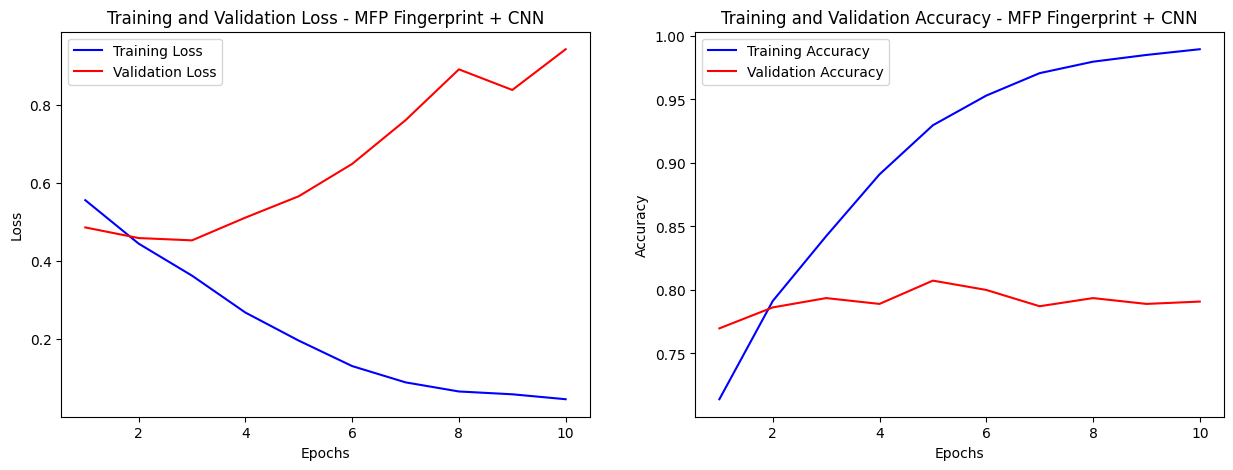

In [234]:
plot_acc_loss_dl(mfp_cnn, 'MFP Fingerprint + CNN')

</p>
<div style="text-align: justify">
Neste caso específico, se os resultados das métricas de validação e treino começam a cruzar-se já no epoch 2, isto pode ser um indicativo de que o modelo está a sobreajustar-se aos dados de treino muito rapidamente. Isto significa que o modelo está a memorizar os exemplos de treino em vez de aprender padrões mais gerais que possam ser aplicados a novos dados.


In [235]:
dl_model_metrics(model_mfp_cnn, test_mfp_converted, y_test, 'MFP Fingerprint + CNN')

 1/35 [..............................] - ETA: 2s

35/35 [==============================] - 0s 7ms/step - loss: 0.8035 - accuracy: 0.8229

################## MFP Fingerprint + CNN ##################

Test loss: 0.8034691214561462
Test accuracy: 0.8229357600212097

- - - - - - - - - - - - - - - - - - - - - - - - -

Confusion Matrix:
[[365  91]
 [102 532]]
- - - - - - - - - - - - - - - - - - - - - - - - -

Classification Report:
               precision    recall  f1-score   support

           0       0.78      0.80      0.79       456
           1       0.85      0.84      0.85       634

    accuracy                           0.82      1090
   macro avg       0.82      0.82      0.82      1090
weighted avg       0.82      0.82      0.82      1090

- - - - - - - - - - - - - - - - - - - - - - - - -

MCC: 0.64
Fowlkes-Mallows Index: 0.85
Bookmaker Informedness: 0.64
DeltaP: 0.27



Neste caso, o modelo classificou corretamente 82.22% dos exemplos, em que previu corretamente 365 exemplos como negativos e 532 exemplos como positivo. Contudo, o modelo previu incorretamente 102 exemplos como positivos e 91 exemplos como negativos.
O F1 Score é de 0.85 (classe positiva) e 0.79 (classe negativa), o que indica um bom equilíbrio entre a precisão e a recall do modelo. Analisando ainda o MCC, com um valor de 0.64 indica uma correlação moderada entre as previsões do modelo e as classes reais, havendo ainda margem para melhorias.

Quanto ao Bookmaker Informedness é de 0.64, o que indica que o modelo tem uma capacidade razoável de fazer previsões informadas.
No caso do DeltaP é de 0.27, indicando que o modelo apresenta uma diferença significativa entre as probabilidades observadas e as probabilidades esperadas de classificações positivas.


De modo a tentar reduzir o overfitting realizou-se o Dropout. Esta é uma técnica de regularização que ajuda a evitar o overfitting, desativando aleatoriamente um certo número de unidades de saída em cada atualização durante o treino. Isto impede que o modelo se torne excessivamente dependente de unidades específicas.

In [242]:
model_mfp_cnn_drop = Sequential()
model_mfp_cnn_drop.add(Conv1D(32, kernel_size=3, activation='relu', input_shape=(1024, 1)))
model_mfp_cnn_drop.add(MaxPooling1D(pool_size=2))
model_mfp_cnn_drop.add(Dropout(0.45))  # Adicionar Dropout
model_mfp_cnn_drop.add(Conv1D(64, kernel_size=3, activation='relu'))
model_mfp_cnn_drop.add(MaxPooling1D(pool_size=2))
model_mfp_cnn_drop.add(Dropout(0.25))  # Adicionar Dropout
model_mfp_cnn_drop.add(Flatten())
model_mfp_cnn_drop.add(Dense(64, activation='relu'))
model_mfp_cnn_drop.add(Dense(1, activation='sigmoid'))

model_mfp_cnn_drop.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

checkpoint = ModelCheckpoint("mfp_cnn_drop.h5", monitor='val_loss', save_best_only=True, mode='min')

mfp_cnn_drop = model_mfp_cnn_drop.fit(converted_data_mfp,y_train,validation_data=(val_mfp_converted, y_val),epochs=10, batch_size=32, callbacks=[checkpoint])

Epoch 1/10
160/160 [==============================] - 7s 40ms/step - loss: 0.5810 - accuracy: 0.6935 - val_loss: 0.5163 - val_accuracy: 0.7440
Epoch 2/10
160/160 [==============================] - 6s 40ms/step - loss: 0.4982 - accuracy: 0.7518 - val_loss: 0.4794 - val_accuracy: 0.7633
Epoch 3/10
160/160 [==============================] - 6s 39ms/step - loss: 0.4428 - accuracy: 0.7879 - val_loss: 0.4625 - val_accuracy: 0.7761
Epoch 4/10
160/160 [==============================] - 6s 39ms/step - loss: 0.3815 - accuracy: 0.8239 - val_loss: 0.4623 - val_accuracy: 0.7670
Epoch 5/10
160/160 [==============================] - 6s 39ms/step - loss: 0.3149 - accuracy: 0.8659 - val_loss: 0.4726 - val_accuracy: 0.7881
Epoch 6/10
160/160 [==============================] - 6s 38ms/step - loss: 0.2563 - accuracy: 0.8916 - val_loss: 0.4931 - val_accuracy: 0.7826
Epoch 7/10
160/160 [==============================] - 6s 38ms/step - loss: 0.1965 - accuracy: 0.9205 - val_loss: 0.6019 - val_accuracy: 0.7798

In [243]:
model_mfp_cnn_drop.load_weights('mfp_cnn_drop.h5')

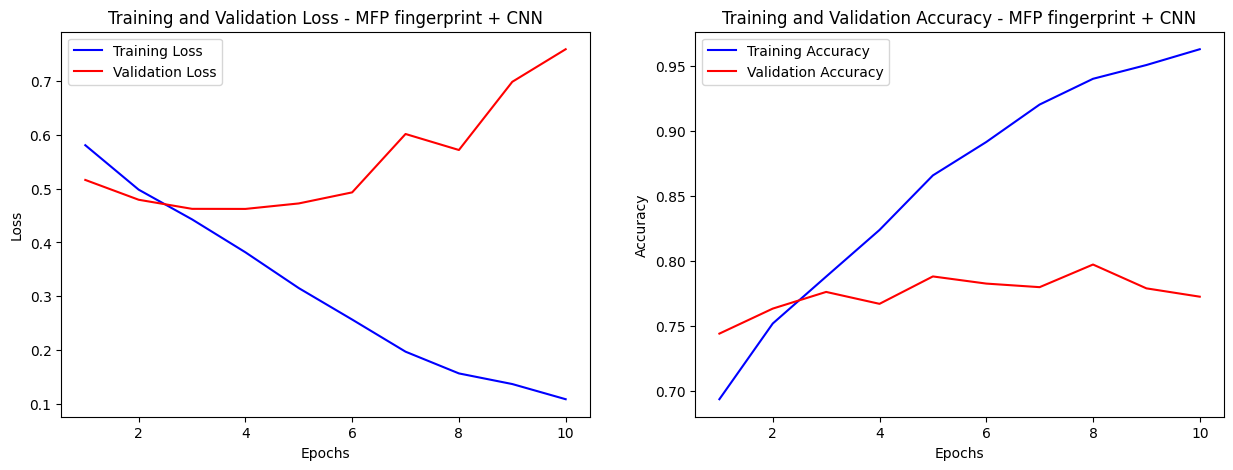

In [245]:
plot_acc_loss_dl(mfp_cnn_drop, 'MFP fingerprint + CNN')

</div>
</p>
<div style="text-align: justify">
Com base nos resultados obtidos, observamos que a accuarcy no conjunto de validação atinge seu pico em torno do epoch 7 e, a partir desse ponto, parece haver uma leve tendência de queda.
</div>
</p>
<div style="text-align: justify">
Portanto, uma opção seria escolher o epoch 7 como o ponto em que o modelo teve melhor desempenho no conjunto de validação. Contudo, tendo em conta os valores de loss, seria melhor escolha o epoch 4.

    

In [246]:
dl_model_metrics(model_mfp_cnn_drop, test_mfp_converted, y_test, 'MFP fingerprint + CNN')

 1/35 [..............................] - ETA: 2s

35/35 [==============================] - 0s 6ms/step - loss: 0.4175 - accuracy: 0.7908

################## MFP fingerprint + CNN ##################

Test loss: 0.41746219992637634
Test accuracy: 0.7908256649971008

- - - - - - - - - - - - - - - - - - - - - - - - -

Confusion Matrix:
[[369  87]
 [141 493]]
- - - - - - - - - - - - - - - - - - - - - - - - -

Classification Report:
               precision    recall  f1-score   support

           0       0.72      0.81      0.76       456
           1       0.85      0.78      0.81       634

    accuracy                           0.79      1090
   macro avg       0.79      0.79      0.79      1090
weighted avg       0.80      0.79      0.79      1090

- - - - - - - - - - - - - - - - - - - - - - - - -

MCC: 0.58
Fowlkes-Mallows Index: 0.81
Bookmaker Informedness: 0.59
DeltaP: 0.27



Após realizar o dropout, a accuracy diminuiu ligeiramente para 79.08% e consequentemente um pequeno aumento nos verdadeiros negativos (de 365 para 369) e uma considerável diminuição nos verdadeiros positivos (de 532 para 493). 
O valor do F1 Score e MCC diminuiram ligeiramente. Isto indica que, embora o modelo ainda tenha um bom equilíbrio entre a precisão e a revocação, houve uma ligeira redução na qualidade geral da classificação.

### MACCS fingerprint - CNNs

In [248]:
x_train_maccs =np.array(train_set["maccs"].values)
test_maccs =np.array( test_set_final["maccs"].values)
val_maccs = np.array(validation_set["maccs"].values)
x_train_maccs

array([<rdkit.DataStructs.cDataStructs.ExplicitBitVect object at 0x000002BD6D270D60>,
       ...,
      dtype=object)

In [249]:
fingerprints = x_train_maccs

In [250]:
num_fingerprints = len(fingerprints)
fingerprint_length = fingerprints[0].GetNumBits()
x_train_maccs = np.zeros((num_fingerprints, fingerprint_length), dtype=int)

for i in range(num_fingerprints):
    DataStructs.ConvertToNumpyArray(fingerprints[i], x_train_maccs[i])

In [251]:
fingerprints = test_maccs

In [252]:
num_fingerprints = len(fingerprints)
fingerprint_length = fingerprints[0].GetNumBits()
test_maccs = np.zeros((num_fingerprints, fingerprint_length), dtype=int)

for i in range(num_fingerprints):
    DataStructs.ConvertToNumpyArray(fingerprints[i], test_maccs[i])

In [253]:
fingerprints = val_maccs

In [254]:
num_fingerprints = len(fingerprints)
fingerprint_length = fingerprints[0].GetNumBits()
val_maccs = np.zeros((num_fingerprints, fingerprint_length), dtype=int)

for i in range(num_fingerprints):
    DataStructs.ConvertToNumpyArray(fingerprints[i], val_maccs[i])

In [255]:
model_maccs_cnn = Sequential()
model_maccs_cnn.add(Conv1D(32, kernel_size=3, activation='relu', input_shape=(167, 1)))
model_maccs_cnn.add(MaxPooling1D(pool_size=2))
model_maccs_cnn.add(Conv1D(64, kernel_size=3, activation='relu'))
model_maccs_cnn.add(MaxPooling1D(pool_size=2))
model_maccs_cnn.add(Flatten())
model_maccs_cnn.add(Dense(64, activation='relu'))
model_maccs_cnn.add(Dense(1, activation='sigmoid'))

model_maccs_cnn.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

checkpoint = ModelCheckpoint("maccs_cnn.h5", monitor='val_loss', save_best_only=True, mode='min')

maccs_cnn = model_maccs_cnn.fit(x_train_maccs,y_train,validation_data=(val_maccs, y_val),epochs=10, batch_size=32,callbacks=[checkpoint])

Epoch 1/10


160/160 [==============================] - 2s 6ms/step - loss: 0.5736 - accuracy: 0.7027 - val_loss: 0.5411 - val_accuracy: 0.7220
Epoch 2/10
160/160 [==============================] - 1s 5ms/step - loss: 0.5158 - accuracy: 0.7518 - val_loss: 0.5053 - val_accuracy: 0.7706
Epoch 3/10
160/160 [==============================] - 1s 5ms/step - loss: 0.4909 - accuracy: 0.7732 - val_loss: 0.4882 - val_accuracy: 0.7697
Epoch 4/10
160/160 [==============================] - 1s 5ms/step - loss: 0.4680 - accuracy: 0.7860 - val_loss: 0.5095 - val_accuracy: 0.7670
Epoch 5/10
160/160 [==============================] - 1s 5ms/step - loss: 0.4443 - accuracy: 0.7974 - val_loss: 0.4852 - val_accuracy: 0.7817
Epoch 6/10
160/160 [==============================] - 1s 5ms/step - loss: 0.4200 - accuracy: 0.8125 - val_loss: 0.4602 - val_accuracy: 0.7936
Epoch 7/10
160/160 [==============================] - 1s 5ms/step - loss: 0.3975 - accuracy: 0.8254 - val_loss: 0.4467 - val_accuracy: 0.8073
Epoch 8/10
160/16

In [256]:
model_maccs_cnn.load_weights("maccs_cnn.h5")

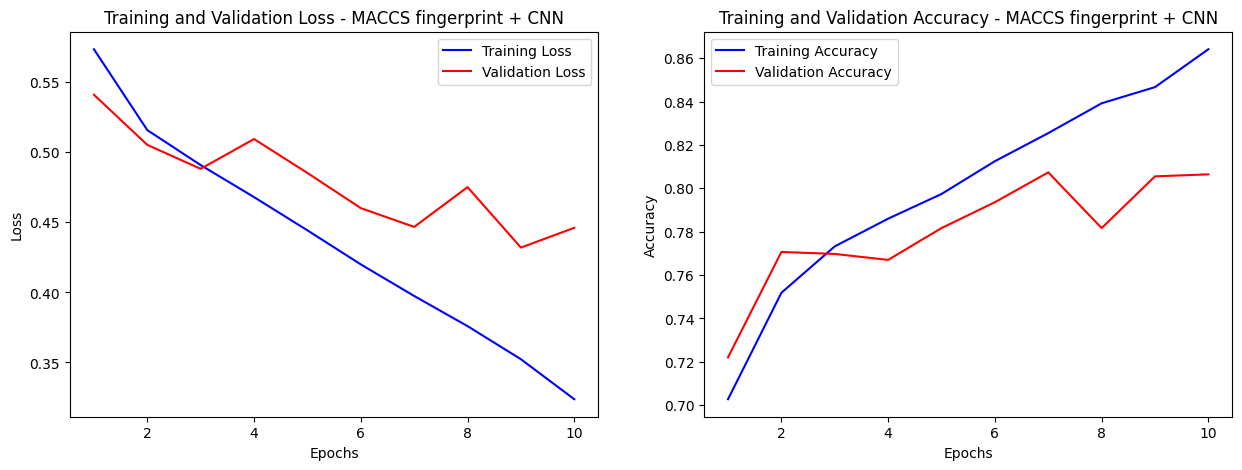

In [257]:
plot_acc_loss_dl(maccs_cnn, 'MACCS fingerprint + CNN')

In [258]:
dl_model_metrics(model_maccs_cnn, test_maccs, y_test, 'MACCS fingerprint + CNN')

 1/35 [..............................] - ETA: 2s

35/35 [==============================] - 0s 2ms/step - loss: 0.4268 - accuracy: 0.8046

################## MACCS fingerprint + CNN ##################

Test loss: 0.42684006690979004
Test accuracy: 0.804587185382843

- - - - - - - - - - - - - - - - - - - - - - - - -

Confusion Matrix:
[[322 134]
 [ 79 555]]
- - - - - - - - - - - - - - - - - - - - - - - - -

Classification Report:
               precision    recall  f1-score   support

           0       0.80      0.71      0.75       456
           1       0.81      0.88      0.84       634

    accuracy                           0.80      1090
   macro avg       0.80      0.79      0.80      1090
weighted avg       0.80      0.80      0.80      1090

- - - - - - - - - - - - - - - - - - - - - - - - -

MCC: 0.59
Fowlkes-Mallows Index: 0.84
Bookmaker Informedness: 0.58
DeltaP: 0.22


</div>
</p>
<div style="text-align: justify">
Os valores das métricas em relação aos modelos anteriores não alteraram muito. Além disso, houve um aumento nos falsos positivos e uma diminuição nos falsos negativos, o que em caso de avaliação de mutagenicidade é mais benéfico em termos da sua aplicabilidade.

### AP fingerprint - CNNs

In [259]:
x_train_ap =np.array(train_set["ap_fingerprint"].values)
test_ap =np.array( test_set_final["ap_fingerprint"].values)
val_ap = np.array(validation_set["ap_fingerprint"].values)
x_train_ap

array([<rdkit.DataStructs.cDataStructs.ExplicitBitVect object at 0x000002BD6DBBF7D0>,
       ...,
      dtype=object)

In [260]:
fingerprints = x_train_ap

In [261]:
num_fingerprints = len(fingerprints)
fingerprint_length = fingerprints[0].GetNumBits()
x_train_ap = np.zeros((num_fingerprints, fingerprint_length), dtype=int)

for i in range(num_fingerprints):
    DataStructs.ConvertToNumpyArray(fingerprints[i], x_train_ap[i])

In [262]:
fingerprints = test_ap

In [263]:
num_fingerprints = len(fingerprints)
fingerprint_length = fingerprints[0].GetNumBits()
test_ap = np.zeros((num_fingerprints, fingerprint_length), dtype=int)

for i in range(num_fingerprints):
    DataStructs.ConvertToNumpyArray(fingerprints[i], test_ap[i])

In [264]:
fingerprints = val_ap

In [265]:
num_fingerprints = len(fingerprints)
fingerprint_length = fingerprints[0].GetNumBits()
val_ap = np.zeros((num_fingerprints, fingerprint_length), dtype=int)

for i in range(num_fingerprints):
    DataStructs.ConvertToNumpyArray(fingerprints[i], val_ap[i])

In [266]:
model_ap_cnn = Sequential()
model_ap_cnn.add(Conv1D(32, kernel_size=3, activation='relu', input_shape=(2048, 1)))
model_ap_cnn.add(MaxPooling1D(pool_size=2))
model_ap_cnn.add(Conv1D(64, kernel_size=3, activation='relu'))
model_ap_cnn.add(MaxPooling1D(pool_size=2))
model_ap_cnn.add(Flatten())
model_ap_cnn.add(Dense(64, activation='relu'))
model_ap_cnn.add(Dense(1, activation='sigmoid'))

model_ap_cnn.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

checkpoint = ModelCheckpoint("ap_cn.h5", monitor='val_loss', save_best_only=True, mode='min')

ap_cnn = model_ap_cnn.fit(x_train_ap,y_train,validation_data=(val_ap, y_val),epochs=10, batch_size=32, callbacks=[checkpoint])

Epoch 1/10
160/160 [==============================] - 11s 62ms/step - loss: 0.5723 - accuracy: 0.7045 - val_loss: 0.4930 - val_accuracy: 0.7495
Epoch 2/10
160/160 [==============================] - 10s 60ms/step - loss: 0.4342 - accuracy: 0.8068 - val_loss: 0.4753 - val_accuracy: 0.7670
Epoch 3/10
160/160 [==============================] - 10s 60ms/step - loss: 0.3498 - accuracy: 0.8498 - val_loss: 0.4514 - val_accuracy: 0.8055
Epoch 4/10
160/160 [==============================] - 10s 60ms/step - loss: 0.2574 - accuracy: 0.8855 - val_loss: 0.4855 - val_accuracy: 0.8028
Epoch 5/10
160/160 [==============================] - 10s 60ms/step - loss: 0.1794 - accuracy: 0.9311 - val_loss: 0.5651 - val_accuracy: 0.8009
Epoch 6/10
160/160 [==============================] - 10s 60ms/step - loss: 0.1124 - accuracy: 0.9582 - val_loss: 0.7268 - val_accuracy: 0.7899
Epoch 7/10
160/160 [==============================] - 9s 59ms/step - loss: 0.0759 - accuracy: 0.9735 - val_loss: 0.8476 - val_accuracy: 

In [268]:
model_ap_cnn.load_weights('ap_cn.h5')

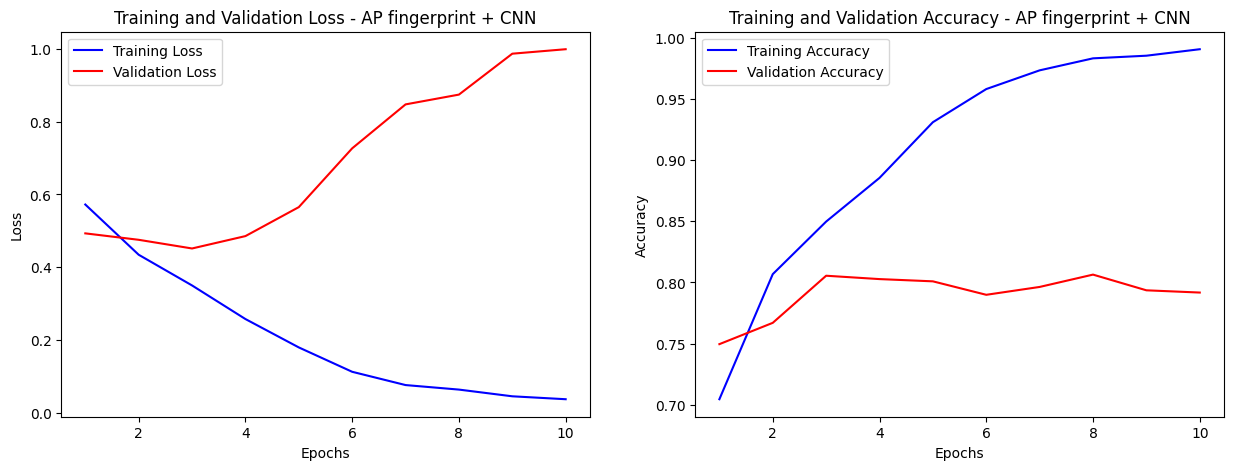

In [269]:
plot_acc_loss_dl(ap_cnn, 'AP fingerprint + CNN')

In [270]:
dl_model_metrics(model_ap_cnn, test_ap, y_test, 'AP fingerprint + CNN')

 1/35 [..............................] - ETA: 2s

35/35 [==============================] - 0s 11ms/step - loss: 0.4239 - accuracy: 0.8009

################## AP fingerprint + CNN ##################

Test loss: 0.4239446520805359
Test accuracy: 0.8009174466133118

- - - - - - - - - - - - - - - - - - - - - - - - -

Confusion Matrix:
[[338 118]
 [ 99 535]]
- - - - - - - - - - - - - - - - - - - - - - - - -

Classification Report:
               precision    recall  f1-score   support

           0       0.77      0.74      0.76       456
           1       0.82      0.84      0.83       634

    accuracy                           0.80      1090
   macro avg       0.80      0.79      0.79      1090
weighted avg       0.80      0.80      0.80      1090

- - - - - - - - - - - - - - - - - - - - - - - - -

MCC: 0.59
Fowlkes-Mallows Index: 0.83
Bookmaker Informedness: 0.59
DeltaP: 0.24



De um modo geral, os resultados com a utilização das fingerprints AP são semelhantes aos resultados anteriores, com algumas métricas a apresentarem pequenas alterações. Isto indica que a este tipo de fingerprint não teve um impacto significativo no desempenho do modelo em relação às fingerprints anteriores.

### TT fingerprint - CNNs

In [271]:
x_train_tt =np.array(train_set["tt_fingerprint"].values)
test_tt =np.array( test_set_final["tt_fingerprint"].values)
val_tt = np.array(validation_set["tt_fingerprint"].values)
x_train_ap

array([[0, 0, 0, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [1, 1, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [272]:
converted_data_tt = np.empty((x_train_tt.shape[0], 2048), dtype=np.float32) # Convert each list in the original data to a numpy array 
for i, row in enumerate(x_train_tt): converted_data_tt[i] = np.array(row, dtype=np.float32) 
test_tt_converted = np.empty((test_tt.shape[0], 2048), dtype=np.float32) # Convert each list in the original data to a numpy array 
for i, row in enumerate(test_tt): test_tt_converted[i] = np.array(row, dtype=np.float32) 
val_tt_converted = np.empty((val_tt.shape[0], 2048), dtype=np.float32) # Convert each list in the original data to a numpy array 
for i, row in enumerate(val_tt): val_tt_converted[i] = np.array(row, dtype=np.float32) 

In [277]:
model_tt_cnn_drop = Sequential()
model_tt_cnn_drop.add(Conv1D(32, kernel_size=3, activation='relu', input_shape=(2048, 1)))
model_tt_cnn_drop.add(MaxPooling1D(pool_size=2))
model_tt_cnn_drop.add(Dropout(0.45))  # Adicionar Dropout
model_tt_cnn_drop.add(Conv1D(64, kernel_size=3, activation='relu'))
model_tt_cnn_drop.add(MaxPooling1D(pool_size=2))
model_tt_cnn_drop.add(Dropout(0.35))  # Adicionar Dropout
model_tt_cnn_drop.add(Flatten())
model_tt_cnn_drop.add(Dense(64, activation='relu'))
model_tt_cnn_drop.add(Dense(1, activation='sigmoid'))

model_tt_cnn_drop.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

checkpoint = ModelCheckpoint("tt_cnn_drop.h5", monitor='val_loss', save_best_only=True, mode='min')

tt_cnn_drop = model_tt_cnn_drop.fit(converted_data_tt,y_train,validation_data=(val_tt_converted, y_val),epochs=10, batch_size=32, callbacks=[checkpoint])

Epoch 1/10
160/160 [==============================] - 13s 75ms/step - loss: 0.5667 - accuracy: 0.7080 - val_loss: 0.5132 - val_accuracy: 0.7486
Epoch 2/10
160/160 [==============================] - 12s 75ms/step - loss: 0.4728 - accuracy: 0.7734 - val_loss: 0.4842 - val_accuracy: 0.7725
Epoch 3/10
160/160 [==============================] - 12s 72ms/step - loss: 0.4160 - accuracy: 0.8042 - val_loss: 0.4718 - val_accuracy: 0.7899
Epoch 4/10
160/160 [==============================] - 12s 74ms/step - loss: 0.3581 - accuracy: 0.8502 - val_loss: 0.4569 - val_accuracy: 0.8009
Epoch 5/10
160/160 [==============================] - 12s 74ms/step - loss: 0.2963 - accuracy: 0.8726 - val_loss: 0.5093 - val_accuracy: 0.7963
Epoch 6/10
160/160 [==============================] - 13s 78ms/step - loss: 0.2562 - accuracy: 0.8918 - val_loss: 0.5444 - val_accuracy: 0.7954
Epoch 7/10
160/160 [==============================] - 13s 81ms/step - loss: 0.2133 - accuracy: 0.9136 - val_loss: 0.5774 - val_accuracy:

In [278]:
model_tt_cnn_drop.load_weights('tt_cnn_drop.h5')

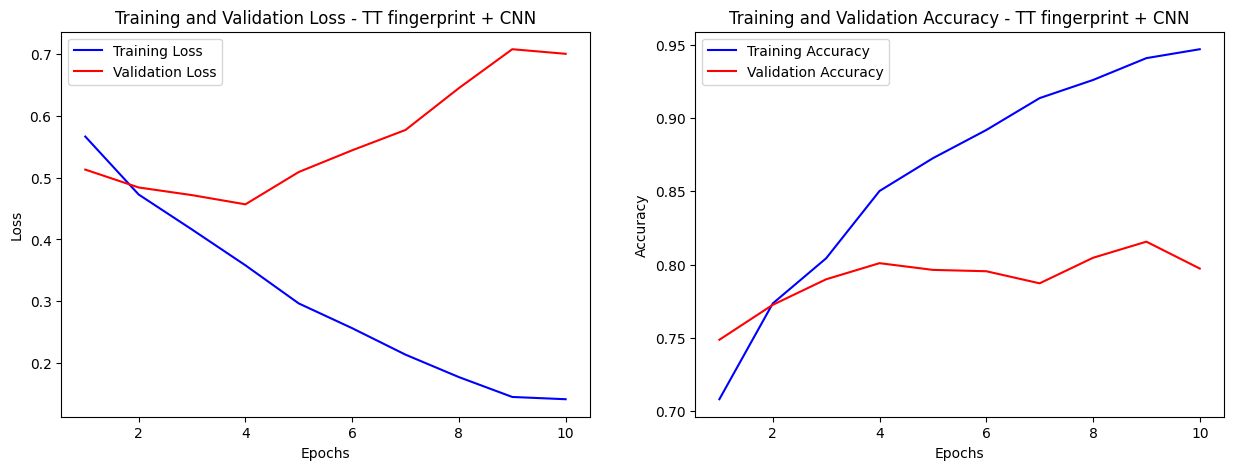

In [279]:
plot_acc_loss_dl(tt_cnn_drop, 'TT fingerprint + CNN')

In [280]:
dl_model_metrics(model_tt_cnn_drop, test_tt_converted, y_test, 'TT fingerprint + CNN')

 6/35 [====>.........................] - ETA: 0s

35/35 [==============================] - 0s 10ms/step - loss: 0.4375 - accuracy: 0.7982

################## TT fingerprint + CNN ##################

Test loss: 0.4374502897262573
Test accuracy: 0.7981651425361633

- - - - - - - - - - - - - - - - - - - - - - - - -

Confusion Matrix:
[[359  97]
 [123 511]]
- - - - - - - - - - - - - - - - - - - - - - - - -

Classification Report:
               precision    recall  f1-score   support

           0       0.74      0.79      0.77       456
           1       0.84      0.81      0.82       634

    accuracy                           0.80      1090
   macro avg       0.79      0.80      0.79      1090
weighted avg       0.80      0.80      0.80      1090

- - - - - - - - - - - - - - - - - - - - - - - - -

MCC: 0.59
Fowlkes-Mallows Index: 0.82
Bookmaker Informedness: 0.59
DeltaP: 0.26



De um modo geral, os resultados com a utilização das fingerprints TT são semelhantes aos resultados das fingerprints anteriores, com algumas métricas a apresentarem pequenas alterações. Isto indica que a este tipo de fingerprint não teve um impacto significativo no desempenho do modelo em relação às fingerprints anteriores.

## RNN - LSTM

As redes LSTM (Long Short-Term Memory) são uma variante especializada das redes neuronais recorrentes (RNNs) que foram projetadas para lidar com problemas que envolvem sequências de dados, como processamento de linguagem natural, tradução automática, reconhecimento de voz, entre outros. Destacam-se pela sua capacidade de capturar dependências temporais de longo prazo em dados sequenciais, superando as limitações das RNNs tradicionais [1].

As redes LSTM podem oferecer uma solução eficaz para a previsão da mutagenicidade em compostos químicos, uma vez que são capazes de aprender padrões e dependências de longo prazo nos dados sequenciais, representativos dos compostos. Com isto, este tipo de redes poderá ter um bom desempenho na classificação de compostos químicos mutagénicos.

#### MFP fingerprint

In [281]:
converted_data_mfp = converted_data_mfp.reshape(converted_data_mfp.shape[0], 1, converted_data_mfp.shape[1])
test_mfp_converted = test_mfp_converted.reshape(test_mfp_converted.shape[0], 1, test_mfp_converted.shape[1])
val_mfp_converted = val_mfp_converted.reshape(val_mfp_converted.shape[0], 1, val_mfp_converted.shape[1])

In [284]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Dropout, LSTM

model_mfp_lstm = Sequential()
model_mfp_lstm.add(LSTM(128, input_shape = (converted_data_mfp.shape[1],converted_data_mfp.shape[2]), activation = 'relu', return_sequences=True))
model_mfp_lstm.add(Dropout(0.2))

model_mfp_lstm.add(LSTM(128, activation = 'relu'))
model_mfp_lstm.add(Dropout(0.2))

model_mfp_lstm.add(Dense(32, activation='relu'))
model_mfp_lstm.add(Dropout(0.2))

model_mfp_lstm.add(Dense(1, activation = 'sigmoid'))

model_mfp_lstm.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

checkpoint = ModelCheckpoint("mfp_lstm.h5", monitor='val_loss', save_best_only=True, mode='min')

mfp_lstm = model_mfp_lstm.fit(converted_data_mfp,y_train,validation_data=(val_mfp_converted, y_val),epochs=10, batch_size=32, callbacks=[checkpoint])

Epoch 1/10
160/160 [==============================] - 4s 11ms/step - loss: 0.6032 - accuracy: 0.6666 - val_loss: 0.4972 - val_accuracy: 0.7734
Epoch 2/10
160/160 [==============================] - 2s 10ms/step - loss: 0.4477 - accuracy: 0.7956 - val_loss: 0.4563 - val_accuracy: 0.7835
Epoch 3/10
160/160 [==============================] - 2s 10ms/step - loss: 0.3523 - accuracy: 0.8520 - val_loss: 0.4371 - val_accuracy: 0.8101
Epoch 4/10
160/160 [==============================] - 2s 10ms/step - loss: 0.2752 - accuracy: 0.8865 - val_loss: 0.4866 - val_accuracy: 0.8073
Epoch 5/10
160/160 [==============================] - 2s 10ms/step - loss: 0.2095 - accuracy: 0.9181 - val_loss: 0.5682 - val_accuracy: 0.8037
Epoch 6/10
160/160 [==============================] - 2s 10ms/step - loss: 0.1624 - accuracy: 0.9383 - val_loss: 0.6353 - val_accuracy: 0.8183
Epoch 7/10
160/160 [==============================] - 2s 11ms/step - loss: 0.1261 - accuracy: 0.9544 - val_loss: 0.6501 - val_accuracy: 0.8092

In [285]:
model_mfp_lstm.load_weights('mfp_lstm.h5')

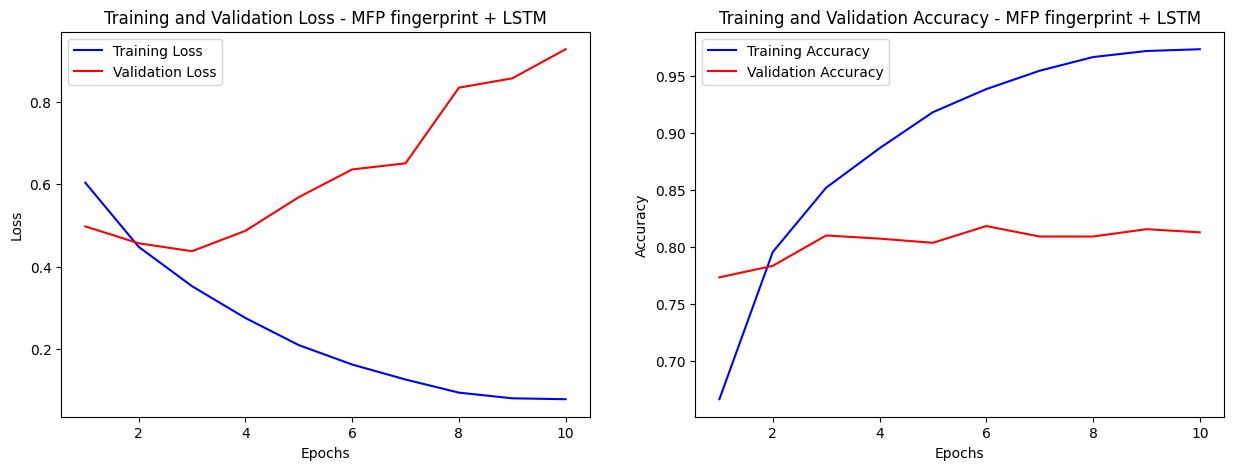

In [286]:
plot_acc_loss_dl(mfp_lstm, 'MFP fingerprint + LSTM')

In [287]:
dl_model_metrics(model_mfp_lstm, test_mfp_converted, y_test, 'MFP fingerprint + LSTM')

35/35 [==============================] - 0s 2ms/step - loss: 0.4155 - accuracy: 0.8294

################## MFP fingerprint + LSTM ##################

Test loss: 0.41548246145248413
Test accuracy: 0.8293578028678894

- - - - - - - - - - - - - - - - - - - - - - - - -

Confusion Matrix:
[[353 103]
 [ 83 551]]
- - - - - - - - - - - - - - - - - - - - - - - - -

Classification Report:
               precision    recall  f1-score   support

           0       0.81      0.77      0.79       456
           1       0.84      0.87      0.86       634

    accuracy                           0.83      1090
   macro avg       0.83      0.82      0.82      1090
weighted avg       0.83      0.83      0.83      1090

- - - - - - - - - - - - - - - - - - - - - - - - -

MCC: 0.65
Fowlkes-Mallows Index: 0.86
Bookmaker Informedness: 0.64
DeltaP: 0.26



Através da vizualização dos gráficos é possível verificar que o melhor epoch é o 3 onde se verifica o valor mais baixo de 'validation loss'. 
Neste caso, o modelo classificou corretamente 82.93% dos exemplos, em que se previu corretamente 353 exemplos como negativos e 551 exemplos como positivos. Contudo, o modelo previu incorretamente 103 exemplos como positivos e 83 exemplos como negativos.

Relativo  ao F1 Score, os resultados apresentam-se satisfatórios, com o valor de 0.79 para a label com pior performance, representando desta forma um bom equilíbrio entre a precisão e a revocação do modelo.

O valor de MCC é 0.65 sugere que o modelo tem uma boa capacidade de realizar previsões corretas, embora ainda haja espaço para melhorias. 

O valor de 0.86 para o Fowlkes-Mallows Index sugere que o modelo o modelo conseguiu identificar padrões relevantes nos dados e agrupá-los de forma semelhante às labels fornecidas.

O valor de 0.64 para o Bookmaker Informedness sugere que o modelo possui um bom nível de informação sobre as classes, embora ainda haja espaço para melhorias sendo o valor optimo 1.

O valor de 0.26 para o DeltaP sugere que o modelo está a melhorar a detecçãoos verdadeiros positivos em relação aos falsos positivos.


#### MACCS Fingerprint

In [288]:
x_train_maccs = x_train_maccs.reshape(x_train_maccs.shape[0], 1, x_train_maccs.shape[1])
test_maccs = test_maccs.reshape(test_maccs.shape[0], 1, test_maccs.shape[1])
val_maccs = val_maccs.reshape(val_maccs.shape[0], 1, val_maccs.shape[1])

In [289]:
model_maccs_lstm = Sequential()
model_maccs_lstm.add(LSTM(128, input_shape = (x_train_maccs.shape[1],x_train_maccs.shape[2]), activation = 'relu', return_sequences=True))
model_maccs_lstm.add(Dropout(0.2))

model_maccs_lstm.add(LSTM(128, activation = 'relu'))
model_maccs_lstm.add(Dropout(0.2))

model_maccs_lstm.add(Dense(32, activation='relu'))
model_maccs_lstm.add(Dropout(0.2))

model_maccs_lstm.add(Dense(1, activation = 'sigmoid'))

model_maccs_lstm.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

checkpoint = ModelCheckpoint("maccs_lstm.h5", monitor='val_loss', save_best_only=True, mode='min')

maccs_lstm = model_maccs_lstm.fit(x_train_maccs,y_train,validation_data=(val_maccs, y_val),epochs=10, batch_size=32, callbacks=[checkpoint])

Epoch 1/10
160/160 [==============================] - 3s 7ms/step - loss: 0.6187 - accuracy: 0.6542 - val_loss: 0.5554 - val_accuracy: 0.7248
Epoch 2/10
160/160 [==============================] - 1s 5ms/step - loss: 0.5223 - accuracy: 0.7432 - val_loss: 0.5029 - val_accuracy: 0.7596
Epoch 3/10
160/160 [==============================] - 1s 5ms/step - loss: 0.4896 - accuracy: 0.7661 - val_loss: 0.4676 - val_accuracy: 0.7853
Epoch 4/10
160/160 [==============================] - 1s 5ms/step - loss: 0.4645 - accuracy: 0.7860 - val_loss: 0.4544 - val_accuracy: 0.7972
Epoch 5/10
160/160 [==============================] - 1s 5ms/step - loss: 0.4396 - accuracy: 0.8015 - val_loss: 0.4507 - val_accuracy: 0.7972
Epoch 6/10
160/160 [==============================] - 1s 6ms/step - loss: 0.4213 - accuracy: 0.8209 - val_loss: 0.4390 - val_accuracy: 0.8055
Epoch 7/10
160/160 [==============================] - 1s 5ms/step - loss: 0.4017 - accuracy: 0.8313 - val_loss: 0.4238 - val_accuracy: 0.8092
Epoch 

In [290]:
model_maccs_lstm.load_weights('maccs_lstm.h5')

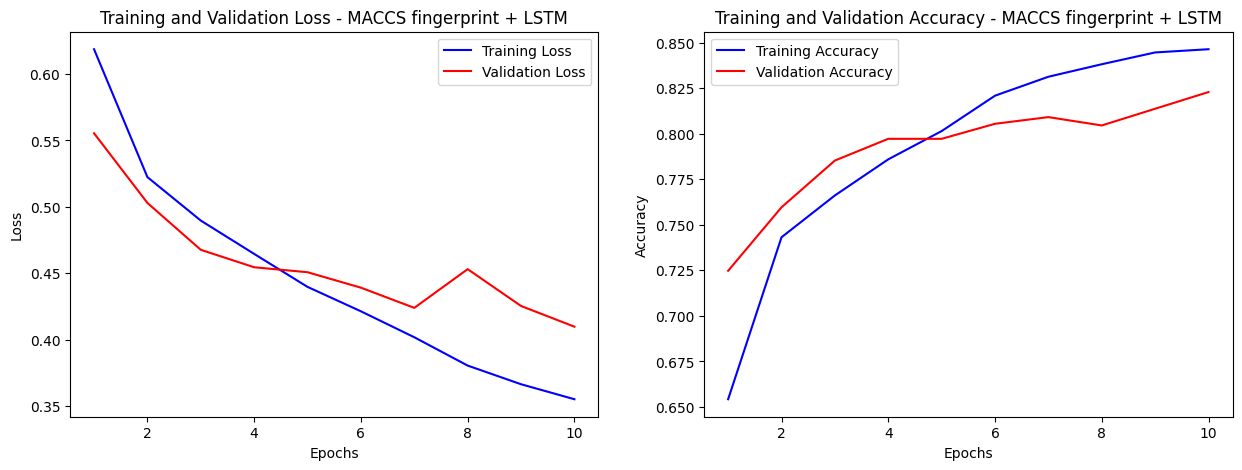

In [291]:
plot_acc_loss_dl(maccs_lstm, 'MACCS fingerprint + LSTM')


In [294]:
dl_model_metrics(model_maccs_lstm, test_maccs, y_test, 'MACCS fingerprint + LSTM')

35/35 [==============================] - 0s 2ms/step - loss: 0.3905 - accuracy: 0.8321

################## MACCS fingerprint + LSTM ##################

Test loss: 0.39053910970687866
Test accuracy: 0.8321101069450378

- - - - - - - - - - - - - - - - - - - - - - - - -

Confusion Matrix:
[[349 107]
 [ 76 558]]
- - - - - - - - - - - - - - - - - - - - - - - - -

Classification Report:
               precision    recall  f1-score   support

           0       0.82      0.77      0.79       456
           1       0.84      0.88      0.86       634

    accuracy                           0.83      1090
   macro avg       0.83      0.82      0.83      1090
weighted avg       0.83      0.83      0.83      1090

- - - - - - - - - - - - - - - - - - - - - - - - -

MCC: 0.65
Fowlkes-Mallows Index: 0.86
Bookmaker Informedness: 0.65
DeltaP: 0.26



Através da análise dos gráficos, foi possível identificar que o melhor epoch foi o 10, onde se obteve o menor valor de 'validation loss'. Nesse caso, o modelo classificou corretamente 83.21% dos exemplos, prevendo corretamente 349 exemplos como negativos e 558 exemplos como positivos. No entanto, ocorreram 76 previsões incorretas de positivos e 107 previsões incorretas de negativos.

No que diz respeito ao F1 Score, os resultados são satisfatórios, com um valor de 0.79 para a classe com pior desempenho. Isso indica um bom equilíbrio entre precisão e recall do modelo.

Em relação às outras métricas, o valor de MCC de 0.65 sugere que o modelo tem uma boa capacidade de fazer previsões corretas, mas ainda há espaço para melhorias. O valor de 0.86 para o Fowlkes-Mallows Index indica que o modelo conseguiu identificar padrões relevantes nos dados e agrupá-los de forma semelhante aos rótulos fornecidos.

O valor de 0.65 para o Bookmaker Informedness sugere que o modelo possui um nível razoável de informação sobre as classes..

Por fim, o valor de 0.26 para o DeltaP indica que o modelo está melhorando a detecção de verdadeiros positivos em relação aos falsos positivos.

### AP fingerprint

In [295]:
x_train_ap = x_train_ap.reshape(x_train_ap.shape[0], 1, x_train_ap.shape[1])
test_ap = test_ap.reshape(test_ap.shape[0], 1, test_ap.shape[1])
val_ap = val_ap.reshape(val_ap.shape[0], 1, val_ap.shape[1])

In [296]:
model_ap_lstm = Sequential()
model_ap_lstm.add(LSTM(128, input_shape = (x_train_ap.shape[1],x_train_ap.shape[2]), activation = 'relu', return_sequences=True))
model_ap_lstm.add(Dropout(0.2))

model_ap_lstm.add(LSTM(128, activation = 'relu'))
model_ap_lstm.add(Dropout(0.2))

model_ap_lstm.add(Dense(32, activation='relu'))
model_ap_lstm.add(Dropout(0.2))

model_ap_lstm.add(Dense(1, activation = 'sigmoid'))

model_ap_lstm.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

checkpoint = ModelCheckpoint("ap_lstm.h5", monitor='val_loss', save_best_only=True, mode='min')

ap_lstm = model_ap_lstm.fit(x_train_ap,y_train,validation_data=(val_ap, y_val),epochs=10, batch_size=32, callbacks=[checkpoint])

Epoch 1/10
160/160 [==============================] - 6s 21ms/step - loss: 0.6208 - accuracy: 0.6523 - val_loss: 0.5186 - val_accuracy: 0.7477
Epoch 2/10
160/160 [==============================] - 3s 20ms/step - loss: 0.4815 - accuracy: 0.7785 - val_loss: 0.4800 - val_accuracy: 0.7725
Epoch 3/10
160/160 [==============================] - 3s 18ms/step - loss: 0.3957 - accuracy: 0.8309 - val_loss: 0.4452 - val_accuracy: 0.8018
Epoch 4/10
160/160 [==============================] - 3s 17ms/step - loss: 0.3245 - accuracy: 0.8618 - val_loss: 0.5087 - val_accuracy: 0.8028
Epoch 5/10
160/160 [==============================] - 3s 18ms/step - loss: 0.2640 - accuracy: 0.8900 - val_loss: 0.5741 - val_accuracy: 0.7972
Epoch 6/10
160/160 [==============================] - 3s 17ms/step - loss: 0.2269 - accuracy: 0.9075 - val_loss: 0.5937 - val_accuracy: 0.7972
Epoch 7/10
160/160 [==============================] - 3s 18ms/step - loss: 0.1929 - accuracy: 0.9211 - val_loss: 0.6967 - val_accuracy: 0.8138

In [297]:
model_ap_lstm.load_weights('ap_lstm.h5')

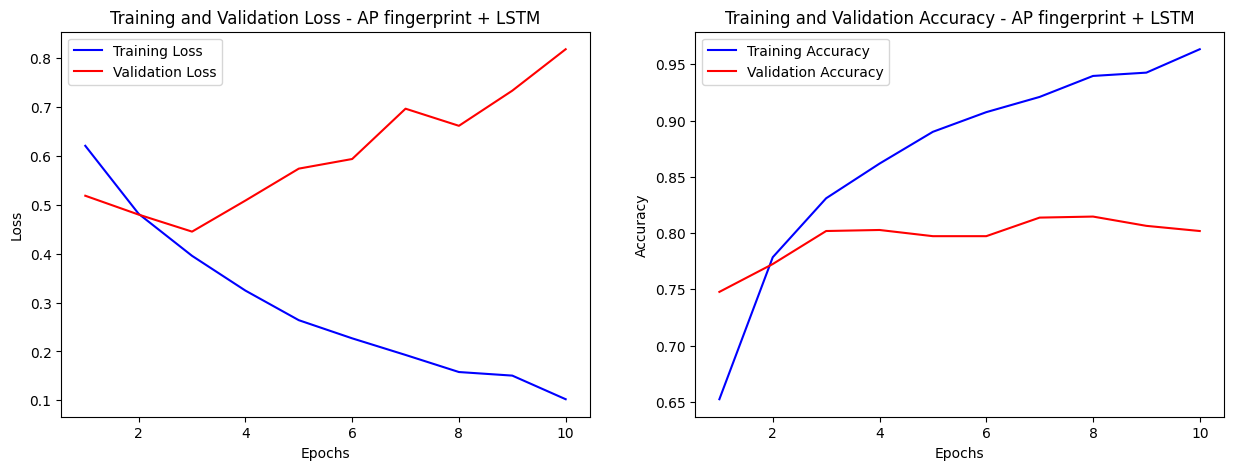

In [298]:
plot_acc_loss_dl(ap_lstm, 'AP fingerprint + LSTM')


In [299]:
dl_model_metrics(model_ap_lstm, test_ap, y_test, 'AP fingerprint + LSTM')

35/35 [==============================] - 0s 2ms/step - loss: 0.4362 - accuracy: 0.8101

################## AP fingerprint + LSTM ##################

Test loss: 0.43617382645606995
Test accuracy: 0.8100917339324951

- - - - - - - - - - - - - - - - - - - - - - - - -

Confusion Matrix:
[[339 117]
 [ 90 544]]
- - - - - - - - - - - - - - - - - - - - - - - - -

Classification Report:
               precision    recall  f1-score   support

           0       0.79      0.74      0.77       456
           1       0.82      0.86      0.84       634

    accuracy                           0.81      1090
   macro avg       0.81      0.80      0.80      1090
weighted avg       0.81      0.81      0.81      1090

- - - - - - - - - - - - - - - - - - - - - - - - -

MCC: 0.61
Fowlkes-Mallows Index: 0.84
Bookmaker Informedness: 0.60
DeltaP: 0.24



Através da análise dos gráficos, foi identificado que o melhor epoch é o 3, onde se obteve o menor valor de 'validation loss'. Neste caso, o modelo classificou corretamente 81% dos exemplos, prevendo corretamente 339 exemplos como negativos e 544 exemplos como positivos. No entanto, ocorreram 90 previsões incorretas de positivos e 117 previsões incorretas de negativos.

Em relação ao F1 Score, os resultados são satisfatórios, com um valor de 0.77 para a classe com pior desempenho. Isso indica um bom equilíbrio entre precisão e recall do modelo.

Considerando outras métricas, o valor de MCC de 0.61 sugere que o modelo tem uma boa capacidade de fazer previsões corretas, mas ainda há espaço para melhorias. O valor de 0.84 para o Fowlkes-Mallows Index indica que o modelo conseguiu identificar padrões relevantes nos dados e agrupá-los de forma semelhante aos rótulos fornecidos.

O valor de 0.60 para o Bookmaker Informedness sugere que o modelo possui um nível razoável de informação sobre as classes.

Em relação ao DeltaP, o valor de 0.24 indica que o modelo está melhorar a detecção de verdadeiros positivos em relação aos falsos positivos

### TT fingerprint

In [300]:
converted_data_tt = converted_data_tt.reshape(converted_data_tt.shape[0], 1, converted_data_tt.shape[1])
test_tt_converted = test_tt_converted.reshape(test_tt_converted.shape[0], 1, test_tt_converted.shape[1])
val_tt_converted = val_tt_converted.reshape(val_tt_converted.shape[0], 1, val_tt_converted.shape[1])

In [301]:
model_tt_lstm = Sequential()
model_tt_lstm.add(LSTM(128, input_shape = (converted_data_tt.shape[1],converted_data_tt.shape[2]), activation = 'relu', return_sequences=True))
model_tt_lstm.add(Dropout(0.2))

model_tt_lstm.add(LSTM(128, activation = 'relu'))
model_tt_lstm.add(Dropout(0.2))

model_tt_lstm.add(Dense(32, activation='relu'))
model_tt_lstm.add(Dropout(0.2))

model_tt_lstm.add(Dense(1, activation = 'sigmoid'))

model_tt_lstm.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

checkpoint = ModelCheckpoint("tt_lstm.h5", monitor='val_loss', save_best_only=True, mode='min')

tt_lstm = model_tt_lstm.fit(converted_data_tt, y_train,validation_data=(val_tt_converted, y_val),epochs=10, batch_size=32, callbacks=[checkpoint])

Epoch 1/10
160/160 [==============================] - 6s 25ms/step - loss: 0.6085 - accuracy: 0.6631 - val_loss: 0.5190 - val_accuracy: 0.7514
Epoch 2/10
160/160 [==============================] - 4s 24ms/step - loss: 0.4740 - accuracy: 0.7850 - val_loss: 0.4789 - val_accuracy: 0.7651
Epoch 3/10
160/160 [==============================] - 4s 24ms/step - loss: 0.3869 - accuracy: 0.8247 - val_loss: 0.4981 - val_accuracy: 0.7734
Epoch 4/10
160/160 [==============================] - 4s 25ms/step - loss: 0.3323 - accuracy: 0.8600 - val_loss: 0.5133 - val_accuracy: 0.7890
Epoch 5/10
160/160 [==============================] - 4s 27ms/step - loss: 0.2800 - accuracy: 0.8800 - val_loss: 0.5541 - val_accuracy: 0.7862
Epoch 6/10
160/160 [==============================] - 4s 26ms/step - loss: 0.2369 - accuracy: 0.8987 - val_loss: 0.5775 - val_accuracy: 0.8000
Epoch 7/10
160/160 [==============================] - 4s 26ms/step - loss: 0.1953 - accuracy: 0.9211 - val_loss: 0.6965 - val_accuracy: 0.7881

In [302]:
model_tt_lstm.load_weights('tt_lstm.h5')

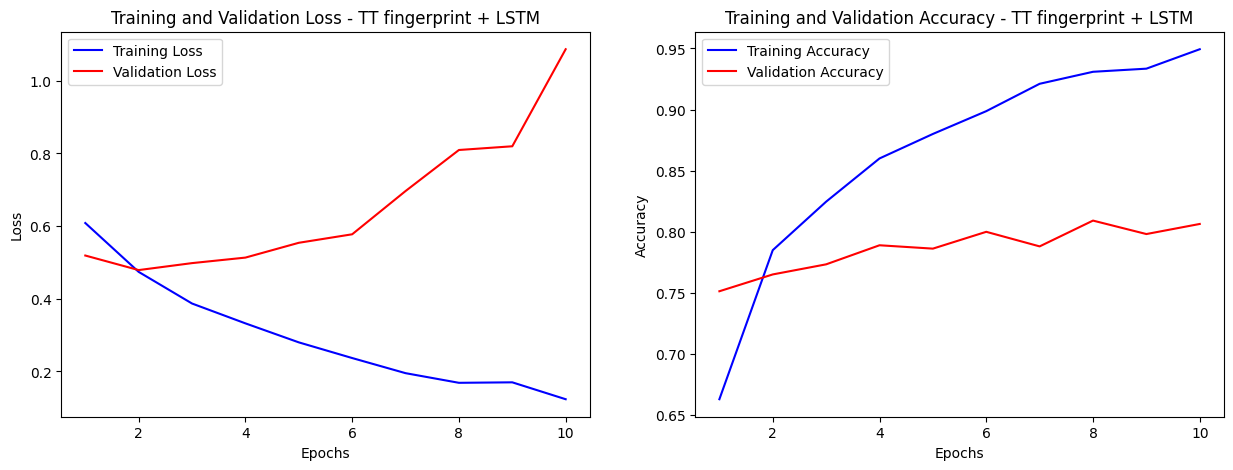

In [303]:
plot_acc_loss_dl(tt_lstm, 'TT fingerprint + LSTM')


In [304]:
dl_model_metrics(model_tt_lstm, test_tt_converted, y_test, 'TT fingerprint + LSTM')

35/35 [==============================] - 0s 5ms/step - loss: 0.4572 - accuracy: 0.7936

################## TT fingerprint + LSTM ##################

Test loss: 0.4572165310382843
Test accuracy: 0.7935779690742493

- - - - - - - - - - - - - - - - - - - - - - - - -

Confusion Matrix:
[[372  84]
 [141 493]]
- - - - - - - - - - - - - - - - - - - - - - - - -

Classification Report:
               precision    recall  f1-score   support

           0       0.73      0.82      0.77       456
           1       0.85      0.78      0.81       634

    accuracy                           0.79      1090
   macro avg       0.79      0.80      0.79      1090
weighted avg       0.80      0.79      0.79      1090

- - - - - - - - - - - - - - - - - - - - - - - - -

MCC: 0.59
Fowlkes-Mallows Index: 0.82
Bookmaker Informedness: 0.59
DeltaP: 0.27



Através da vizualização dos gráficos é possível verificar que o melhor epoch é o 2 onde se verifica o valor mais baixo de 'validation loss'. 
Neste caso, o modelo classificou corretamente 79.35% dos exemplos, em que se previu corretamente 372 exemplos como negativos e 493 exemplos como positivos. Contudo, o modelo previu incorretamente 141 exemplos como positivos e 84 exemplos como negativos.

Relativo  ao F1 Score, os resultados apresentam-se satisfatórios, com o valor de 0.77 para a label com pior performance, representando desta forma um bom equilíbrio entre a precisão e a revocação do modelo.

O valor de MCC é 0.59 sugere que o modelo tem uma boa capacidade de realizar previsões corretas, embora ainda haja espaço para melhorias. 

O valor de 0.82 para o Fowlkes-Mallows Index sugere que o modelo o modelo conseguiu identificar padrões relevantes nos dados e agrupá-los de forma semelhante às labels fornecidas.

O valor de 0.59 para o Bookmaker Informedness sugere que o modelo possui um bom nível de informação sobre as classes, embora ainda haja espaço para melhorias sendo o valor optimo 1.

O valor de 0.27 para o DeltaP sugere que o modelo está a melhorar a detecçãoos verdadeiros positivos em relação aos falsos positivos.


### Comparação dos modelos de Deep Learning (CNN e LSTM) ###


Ao analisarmos os resultados podemos ver que em termos de 'accuracy' os modelos CNN e LSTM são semelhantes em todas as 'fingerprints', com apenas, pequenas variações em alguns casos. Em termos da matriz de confusão a distribuição de verdadeiros positivos, falsos positivos, falsos negativos e verdadeiros negativos é específica para cada fingerprinting e não mostra uma clara vantagem para nenhum dos modelos. O F1 score mostra-se bastante semelhante também em ambos os modelos, o que se pode verificar também no resto das métricas de avaliação, onde ambos os modelos teem desempenhos muito similares. 

Dito isto ambos os modelos, apesar de apresentarem resultados que pouco divergem, usam algoritmos e métodos diferentes para efetuar a sua previsão, mas neste caso, pelos resultados apresentados ambos os modelos conseguem obter scores bastante satisfatórios. Esta similiaridade no desempenho pode estar também associada a uma semelhança entre os diferentes tipos de fingerprints.


## Importância de features

Uma vez analisados todos os modelos construidos, decidiu-se estudar quais seriam as features com maior peso/importância nos modelos de maior performance. Neste caso, uma vez que ao longo do trabalho foi já send realizada uma análise mais pormenorizada das fingerprints de cada molécula, decidmos que nesta fase seria de maior interesse a análise dos descritores modeculares. 

O modelo que apresentou os melhores resultados quando em combinação com os descritores moleculares (features) foi o KNN. Assim sendo, a análise da importância destas features será realizada a partir deste modelo.

In [72]:
import eli5
param_grid = {'n_neighbors':[2, 5, 10, 20, 30],
            'weights':['uniform','distance']}
scaler = StandardScaler()

X_train_descriptors = scaler.fit_transform(train_set_descriptors.iloc[:,:-1])
y_train_descriptors = train_set_descriptors['Y']
X_test_descriptors = scaler.fit_transform(test_set_descriptors.iloc[:,:-1])
y_test_descriptors = test_set_descriptors['Y']
# Classificador SVM
classifier = GridSearchCV(KNeighborsClassifier(), param_grid, cv = 5) 
classifier.fit(X_train_descriptors, y_train_descriptors)

perm = eli5.sklearn.PermutationImportance(classifier.best_estimator_).fit(X_train_descriptors, y_train_descriptors)
eli5.show_weights(perm, feature_names = list(test_set_descriptors.iloc[:,:-1].columns))

Weight,Feature
0.0410 ± 0.0053,FpDensityMorgan2
0.0403 ± 0.0074,MaxPartialCharge
0.0398 ± 0.0045,FpDensityMorgan1
0.0393 ± 0.0065,MaxAbsEStateIndex
0.0392 ± 0.0065,MinAbsPartialCharge
0.0390 ± 0.0054,EState_VSA7
0.0389 ± 0.0053,MaxEStateIndex
0.0383 ± 0.0051,qed
0.0382 ± 0.0067,VSA_EState6
0.0381 ± 0.0061,SMR_VSA7


### Conclusão

 </div>
</p>
<div style="text-align: justify">
A performance do CNN e LSTM é equiparado no que toca a prever a mutagenecidade através das fingerprints utilizados, e ao comparar estes com os modelos de clássicos de Machine Learning, reparamos que mostram maior precisão e eficiência do que os modelos SVM e Naive-Bayes, no entanto é observado um desempenho bastante competitivo com o modelo KNN.
</p>
Com isto podemos referenciar 3 modelos e as correspondentes 'fingerprints', que mostraram melhores resultados e, os quais podemos especular, serem os mais adequados (dos que foram testados) para a previsão da mutagenecidade, o KNN com MFP 'fingerprinting', com 82% de 'accuracy' e um MCC de 0.64, o LSTM com o MACCS 'fingerprinting' com 83.21% de accuracy e um MCC de 0.65 e por fim o CNN, também com o MFP 'fingerprinting' com 82.09% de 'accuracy' e 0.64 de MCC. Existem ainda vários modelos que poderiam ser testados para este propósito como por exemplo o Random Forest ou Decision Tree. De salientar que, para o dataset utilizado, grande parte dos modelos de deep learning apresentaram características de overfitting, indicando que o modelo estaria a memorizar os dados e não a aprender a generalizar.
</p>
 No entanto, os nossos conjuntos de modelos e fingerprints exibem resultados elevados tendo desta forma uma valorição positiva para a previsão da mutagenecidade, sendo uma boa base para futuros estudos.


### Bibliografia
</p>
<div style="text-align: justify">
1. McCarrSeal, A., Passi, A., Jaleel, U. A., Open Source Drug Discovery Consortium info@ osdd. net, & Wild, D. J. (2012). In-silico predictive mutagenicity model generation using supervised learning approaches. Journal of cheminformatics, 4, 1-11.en, P., Springer, C., & Whitehead, L. (2011). An investigation into pharmaceutically relevant mutagenicity data and the influence on Ames predictive potential. Journal of cheminformatics, 3(1), 1-20.</div>
</p>
<div style="text-align: justify">
2. Seal, A., Passi, A., Jaleel, U. A., Open Source Drug Discovery Consortium info@ osdd. net, & Wild, D. J. (2012). In-silico predictive mutagenicity model generation using supervised learning approaches. Journal of cheminformatics, 4, 1-11.</div>
</p>
<div style="text-align: justify">
3. Webb, S. J., Hanser, T., Howlin, B., Krause, P., & Vessey, J. D. (2014). Feature combination networks for the interpretation of statistical machine learning models: application to Ames mutagenicity. Journal of cheminformatics, 6(1), 1-21.</div>
</p>
<div style="text-align: justify">
4. Zhang, Q. Y., & Aires-de-Sousa, J. (2007). Random forest prediction of mutagenicity from empirical physicochemical descriptors. Journal of chemical information and modeling, 47(1), 1-8. </div>
</p>
<div style="text-align: justify">  
5. Xu, C., Cheng, F., Chen, L., Du, Z., Li, W., Liu, G., ... & Tang, Y. (2012). In silico prediction of chemical Ames mutagenicity. Journal of chemical information and modeling, 52(11), 2840-2847.
</div>
</p>
<div style="text-align: justify"> 
6. Chu, C. S., Simpson, J. D., O'Neill, P. M., & Berry, N. G. (2021). Machine learning–Predicting Ames mutagenicity of small molecules. Journal of Molecular Graphics and Modelling, 109, 108011.
</div>
</p>
<div style="text-align: justify"> 
7. Cerruela Garcia, G., García-Pedrajas, N., Luque Ruiz, I., & Gómez-Nieto, M. Á. (2018). An ensemble approach for in silico prediction of Ames mutagenicity. Journal of Mathematical Chemistry, 56, 2085-2098.
</div>
</p>
<div style="text-align: justify">     
8.  Kumar, R., Khan, F. U., Sharma, A., Siddiqui, M. H., Aziz, I. B., Kamal, M. A., ... & Uddin, M. S. (2021). A deep neural network–based approach for prediction of mutagenicity of compounds. Environmental Science and Pollution Research, 28(34), 47641-47650.
</div>
</p>
<div style="text-align: justify">  
9. Shi, T., Yang, Y., Huang, S., Chen, L., Kuang, Z., Heng, Y., & Mei, H. (2019). Molecular image-based convolutional neural network for the prediction of ADMET properties. Chemometrics and Intelligent Laboratory Systems, 194, 103853.
</div>
</p>
<div style="text-align: justify">      
10. Gini, G., Zanoli, F., Gamba, A., Raitano, G., & Benfenati, E. (2019). Could deep learning in neural networks improve the QSAR models?. SAR and QSAR in Environmental Research, 30(9), 617-642.
</div>
</p>
<div style="text-align: justify">   
11. Hung, C., & Gini, G. (2021). QSAR modeling without descriptors using graph convolutional neural networks: the case of mutagenicity prediction. Molecular diversity, 25(3), 1283-1299.